In [1]:
# August 2023
# './data/train_1' to './data/forest' folder for forest dataset.

In [2]:
import time
import os
import math
from time import gmtime, strftime
from datetime import datetime
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data
from torchfoldext import FoldExt
import util
from dynamicplot import DynamicPlot
from IPython.core.debugger import set_trace

from data import ROctDataset
from ROctNetmodel_32 import ROctEncoder
from ROctNetmodel_32 import ROctDecoder
import ROctNetmodel_32

In [3]:
config = util.get_args()

#config.box_code_size = 2744
config.feature_size = 80
config.hidden_size = 200
  
config.show_log_every = 1
config.save_log = False
config.save_log_every = 3
config.save_snapshot = True
config.save_snapshot_every = 50
config.no_plot = False


#  - May 20 from false to True
# config.no_cuda = False #False if using CUDA

#  + May 20 from false to True
config.no_cuda = True #False if using CUDA


config.cuda = not config.no_cuda
config.gpu = 0
config.data_path = 'data'
config.save_path = 'models'


config.batch_size = 1
config.epochs = 20000
incre = 1
n_samples = 1

# #for memory test
# config.batch_size = 50
# config.epochs = 2000
# incre = 100
# n_samples = 100

config.cuda = not config.no_cuda
if config.gpu<0 and config.cuda:
    config.gpu = 1
    torch.cuda.set_device(config.gpu)

if config.cuda and torch.cuda.is_available():
    print("Using CUDA on GPU ", config.gpu)
else:
    print("Not using CUDA.")

encoder = ROctEncoder(config)
decoder = ROctDecoder(config)

Not using CUDA.


/home/sobhan/Documents/py-practice/Rocnet/Forest-scene-Reconstruction-Rocnet/ROctNetmodel_32.py:79: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/home/sobhan/Documents/py-practice/Rocnet/Forest-scene-Reconstruction-Rocnet/ROctNetmodel_32.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/home/sobhan/Documents/py-practice/Rocnet/Forest-scene-Reconstruction-Rocnet/ROctNetmodel_32.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  m.weight.data = nn.init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))
/home/sobhan/Documents/py-practice/Rocnet/Forest-scene-Reconstruction-Rocnet/ROctNetmodel_32.py:410: UserWarning: nn.init.xavier_uniform is now dep

In [ ]:
def my_collate(batch):
    return batch
# print("Loading data ...... ", flush=True)
# roct_data = ROctDataset('/data/juncheng/modelnet40/256_32_vox/train_1',1 , 7512)#7081 4441
# #roct_data.trees = roct_data.trees[0:-1:12]
# train_iter = torch.utils.data.DataLoader(roct_data, batch_size=config.batch_size, shuffle=True, collate_fn=my_collate)
# print("DONE")

# len(roct_data.trees)

In [ ]:
# decoder = torch.load('models/ae_decoder_car_32.pkl')
# encoder = torch.load('models/ae_encoder_car_32.pkl')

In [ ]:
if config.cuda:
    encoder.cuda(config.gpu)
    decoder.cuda(config.gpu)

In [ ]:
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=5e-3)
decoder_opt = torch.optim.Adam(decoder.parameters(), lr=5e-3)

In [ ]:
# + July 2023, not working..! 
# from torchsummary import summary
# summary(encoder, (1,32,32,32), batch_size=5)

In [ ]:
encoder = encoder.train()
decoder = decoder.train()

 00:19:49   281/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:19:53   282/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:19:57   283/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:20:02   284/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:20:06   285/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:20:12   286/20000      1/1         1/1           1.4%        0.05        0.00       0.05
     Time    Epoch   C

 00:23:18   328/20000      1/1         1/1           1.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:23:22   329/20000      1/1         1/1           1.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:23:27   330/20000      1/1         1/1           1.7%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:23:31   331/20000      1/1         1/1           1.7%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:23:36   332/20000      1/1         1/1           1.7%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:23:40   333/20000      1/1         1/1           1.7%        0.05        0.00       0.05
     Time    Epoch   C

 00:26:41   375/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:26:46   376/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:26:50   377/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:26:54   378/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:26:58   379/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:27:03   380/20000      1/1         1/1           1.9%        0.05        0.00       0.05
     Time    Epoch   C

 00:30:00   422/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:30:04   423/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:30:08   424/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:30:12   425/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:30:17   426/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:30:21   427/20000      1/1         1/1           2.1%        0.05        0.00       0.05
     Time    Epoch   C

 00:33:18   469/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:33:22   470/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:33:27   471/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:33:31   472/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:33:35   473/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:33:39   474/20000      1/1         1/1           2.4%        0.05        0.00       0.05
     Time    Epoch   C

 00:36:40   516/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:36:44   517/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:36:48   518/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:36:53   519/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:36:57   520/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:37:01   521/20000      1/1         1/1           2.6%        0.05        0.00       0.05
     Time    Epoch   C

 00:39:57   563/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:40:01   564/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:40:05   565/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:40:09   566/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:40:14   567/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:40:18   568/20000      1/1         1/1           2.8%        0.05        0.00       0.05
     Time    Epoch   C

 00:43:15   610/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:43:20   611/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:43:24   612/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:43:28   613/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:43:32   614/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:43:36   615/20000      1/1         1/1           3.1%        0.05        0.00       0.05
     Time    Epoch   C

 00:46:34   657/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:46:38   658/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:46:42   659/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:46:46   660/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:46:50   661/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:46:55   662/20000      1/1         1/1           3.3%        0.04        0.00       0.04
     Time    Epoch   C

 00:49:52   704/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:49:57   705/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:50:01   706/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:50:05   707/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:50:09   708/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:50:13   709/20000      1/1         1/1           3.5%        0.04        0.00       0.04
     Time    Epoch   C

 00:53:11   751/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:53:15   752/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:53:19   753/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:53:23   754/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:53:28   755/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:53:32   756/20000      1/1         1/1           3.8%        0.04        0.00       0.04
     Time    Epoch   C

 00:56:28   798/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:56:33   799/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:56:37   800/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:56:41   801/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:56:46   802/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:56:50   803/20000      1/1         1/1           4.0%        0.04        0.00       0.04
     Time    Epoch   C

 00:59:46   845/20000      1/1         1/1           4.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:59:51   846/20000      1/1         1/1           4.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:59:55   847/20000      1/1         1/1           4.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 00:59:59   848/20000      1/1         1/1           4.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:00:03   849/20000      1/1         1/1           4.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:00:08   850/20000      1/1         1/1           4.3%        0.04        0.00       0.04
     Time    Epoch   C

 01:03:05   892/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:03:09   893/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:03:13   894/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:03:17   895/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:03:22   896/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:03:26   897/20000      1/1         1/1           4.5%        0.04        0.00       0.04
     Time    Epoch   C

 01:06:24   939/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:06:28   940/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:06:33   941/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:06:37   942/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:06:41   943/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:06:45   944/20000      1/1         1/1           4.7%        0.04        0.00       0.04
     Time    Epoch   C

 01:09:50   986/20000      1/1         1/1           4.9%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:09:55   987/20000      1/1         1/1           4.9%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:10:00   988/20000      1/1         1/1           4.9%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:10:04   989/20000      1/1         1/1           5.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:10:08   990/20000      1/1         1/1           5.0%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:10:13   991/20000      1/1         1/1           5.0%        0.04        0.00       0.04
     Time    Epoch   C

 01:13:12  1033/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:13:17  1034/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:13:21  1035/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:13:25  1036/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:13:29  1037/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:13:34  1038/20000      1/1         1/1           5.2%        0.04        0.00       0.04
     Time    Epoch   C

 01:16:32  1080/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:16:36  1081/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:16:41  1082/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:16:45  1083/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:16:49  1084/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:16:53  1085/20000      1/1         1/1           5.4%        0.04        0.00       0.04
     Time    Epoch   C

 01:19:52  1127/20000      1/1         1/1           5.6%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:19:56  1128/20000      1/1         1/1           5.6%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:20:01  1129/20000      1/1         1/1           5.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:20:05  1130/20000      1/1         1/1           5.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:20:09  1131/20000      1/1         1/1           5.7%        0.04        0.00       0.04
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:20:13  1132/20000      1/1         1/1           5.7%        0.04        0.00       0.04
     Time    Epoch   C

 01:23:12  1174/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:23:16  1175/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:23:20  1176/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:23:25  1177/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:23:29  1178/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:23:33  1179/20000      1/1         1/1           5.9%        0.03        0.00       0.03
     Time    Epoch   C

 01:26:31  1221/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:26:35  1222/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:26:39  1223/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:26:44  1224/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:26:48  1225/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:26:52  1226/20000      1/1         1/1           6.1%        0.03        0.00       0.03
     Time    Epoch   C

 01:29:50  1268/20000      1/1         1/1           6.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:29:54  1269/20000      1/1         1/1           6.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:29:58  1270/20000      1/1         1/1           6.4%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:30:03  1271/20000      1/1         1/1           6.4%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:30:07  1272/20000      1/1         1/1           6.4%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:30:11  1273/20000      1/1         1/1           6.4%        0.03        0.00       0.03
     Time    Epoch   C

 01:33:09  1315/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:33:13  1316/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:33:18  1317/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:33:22  1318/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:33:26  1319/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:33:30  1320/20000      1/1         1/1           6.6%        0.03        0.00       0.03
     Time    Epoch   C

 01:36:27  1362/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:36:31  1363/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:36:36  1364/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:36:40  1365/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:36:44  1366/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:36:48  1367/20000      1/1         1/1           6.8%        0.03        0.00       0.03
     Time    Epoch   C

 01:39:45  1409/20000      1/1         1/1           7.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:39:49  1410/20000      1/1         1/1           7.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:39:53  1411/20000      1/1         1/1           7.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:39:57  1412/20000      1/1         1/1           7.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:40:02  1413/20000      1/1         1/1           7.1%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:40:06  1414/20000      1/1         1/1           7.1%        0.03        0.00       0.03
     Time    Epoch   C

 01:43:02  1456/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:43:06  1457/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:43:10  1458/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:43:14  1459/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:43:19  1460/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:43:23  1461/20000      1/1         1/1           7.3%        0.03        0.00       0.03
     Time    Epoch   C

 01:46:20  1503/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:46:24  1504/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:46:28  1505/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:46:32  1506/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:46:37  1507/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:46:41  1508/20000      1/1         1/1           7.5%        0.03        0.00       0.03
     Time    Epoch   C

 01:49:39  1550/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:49:43  1551/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:49:47  1552/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:49:51  1553/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:49:56  1554/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:50:00  1555/20000      1/1         1/1           7.8%        0.03        0.00       0.03
     Time    Epoch   C

 01:52:57  1597/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:53:01  1598/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:53:06  1599/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:53:10  1600/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:53:14  1601/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:53:18  1602/20000      1/1         1/1           8.0%        0.03        0.00       0.03
     Time    Epoch   C

 01:56:15  1644/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:56:19  1645/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:56:24  1646/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:56:28  1647/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:56:32  1648/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:56:37  1649/20000      1/1         1/1           8.2%        0.03        0.00       0.03
     Time    Epoch   C

 01:59:34  1691/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:59:38  1692/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:59:42  1693/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:59:47  1694/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:59:51  1695/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 01:59:55  1696/20000      1/1         1/1           8.5%        0.03        0.00       0.03
     Time    Epoch   C

 02:02:52  1738/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:02:57  1739/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:03:01  1740/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:03:05  1741/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:03:09  1742/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:03:14  1743/20000      1/1         1/1           8.7%        0.03        0.00       0.03
     Time    Epoch   C

 02:06:12  1785/20000      1/1         1/1           8.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:06:16  1786/20000      1/1         1/1           8.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:06:20  1787/20000      1/1         1/1           8.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:06:24  1788/20000      1/1         1/1           8.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:06:29  1789/20000      1/1         1/1           8.9%        0.03        0.00       0.03
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:06:33  1790/20000      1/1         1/1           9.0%        0.03        0.00       0.03
     Time    Epoch   C

 02:09:31  1832/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:09:35  1833/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:09:39  1834/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:09:43  1835/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:09:47  1836/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:09:52  1837/20000      1/1         1/1           9.2%        0.02        0.00       0.02
     Time    Epoch   C

 02:12:48  1879/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:12:53  1880/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:12:57  1881/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:13:01  1882/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:13:05  1883/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:13:09  1884/20000      1/1         1/1           9.4%        0.02        0.00       0.02
     Time    Epoch   C

 02:16:07  1926/20000      1/1         1/1           9.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:16:11  1927/20000      1/1         1/1           9.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:16:15  1928/20000      1/1         1/1           9.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:16:19  1929/20000      1/1         1/1           9.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:16:23  1930/20000      1/1         1/1           9.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:16:28  1931/20000      1/1         1/1           9.7%        0.02        0.00       0.02
     Time    Epoch   C

 02:19:26  1973/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:19:30  1974/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:19:34  1975/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:19:38  1976/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:19:42  1977/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:19:46  1978/20000      1/1         1/1           9.9%        0.02        0.00       0.02
     Time    Epoch   C

 02:22:44  2020/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:22:48  2021/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:22:52  2022/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:22:57  2023/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:23:01  2024/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:23:05  2025/20000      1/1         1/1          10.1%        0.02        0.00       0.02
     Time    Epoch   C

 02:26:03  2067/20000      1/1         1/1          10.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:26:07  2068/20000      1/1         1/1          10.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:26:11  2069/20000      1/1         1/1          10.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:26:15  2070/20000      1/1         1/1          10.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:26:19  2071/20000      1/1         1/1          10.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:26:24  2072/20000      1/1         1/1          10.4%        0.02        0.00       0.02
     Time    Epoch   C

 02:29:22  2114/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:29:26  2115/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:29:30  2116/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:29:34  2117/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:29:39  2118/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:29:43  2119/20000      1/1         1/1          10.6%        0.02        0.00       0.02
     Time    Epoch   C

 02:32:40  2161/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:32:44  2162/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:32:48  2163/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:32:53  2164/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:32:57  2165/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:33:01  2166/20000      1/1         1/1          10.8%        0.02        0.00       0.02
     Time    Epoch   C

 02:35:58  2208/20000      1/1         1/1          11.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:36:02  2209/20000      1/1         1/1          11.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:36:06  2210/20000      1/1         1/1          11.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:36:10  2211/20000      1/1         1/1          11.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:36:15  2212/20000      1/1         1/1          11.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:36:19  2213/20000      1/1         1/1          11.1%        0.02        0.00       0.02
     Time    Epoch   C

 02:39:16  2255/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:39:20  2256/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:39:25  2257/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:39:29  2258/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:39:33  2259/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:39:37  2260/20000      1/1         1/1          11.3%        0.02        0.00       0.02
     Time    Epoch   C

 02:42:34  2302/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:42:38  2303/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:42:43  2304/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:42:47  2305/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:42:51  2306/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:42:55  2307/20000      1/1         1/1          11.5%        0.02        0.00       0.02
     Time    Epoch   C

 02:45:52  2349/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:45:56  2350/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:46:00  2351/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:46:05  2352/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:46:09  2353/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:46:13  2354/20000      1/1         1/1          11.8%        0.02        0.00       0.02
     Time    Epoch   C

 02:49:10  2396/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:49:15  2397/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:49:19  2398/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:49:24  2399/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:49:28  2400/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:49:32  2401/20000      1/1         1/1          12.0%        0.02        0.00       0.02
     Time    Epoch   C

 02:52:28  2443/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:52:33  2444/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:52:37  2445/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:52:41  2446/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:52:45  2447/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:52:50  2448/20000      1/1         1/1          12.2%        0.02        0.00       0.02
     Time    Epoch   C

 02:55:47  2490/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:55:51  2491/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:55:55  2492/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:56:00  2493/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:56:04  2494/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:56:08  2495/20000      1/1         1/1          12.5%        0.02        0.00       0.02
     Time    Epoch   C

 02:59:05  2537/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:59:09  2538/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:59:13  2539/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:59:17  2540/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:59:21  2541/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 02:59:26  2542/20000      1/1         1/1          12.7%        0.02        0.00       0.02
     Time    Epoch   C

 03:02:22  2584/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:02:26  2585/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:02:30  2586/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:02:35  2587/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:02:39  2588/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:02:43  2589/20000      1/1         1/1          12.9%        0.02        0.00       0.02
     Time    Epoch   C

 03:05:42  2631/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:05:46  2632/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:05:50  2633/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:05:55  2634/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:05:59  2635/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:06:03  2636/20000      1/1         1/1          13.2%        0.02        0.00       0.02
     Time    Epoch   C

 03:08:59  2678/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:09:04  2679/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:09:08  2680/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:09:12  2681/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:09:16  2682/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:09:21  2683/20000      1/1         1/1          13.4%        0.02        0.00       0.02
     Time    Epoch   C

 03:12:17  2725/20000      1/1         1/1          13.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:12:21  2726/20000      1/1         1/1          13.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:12:25  2727/20000      1/1         1/1          13.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:12:29  2728/20000      1/1         1/1          13.6%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:12:34  2729/20000      1/1         1/1          13.7%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:12:38  2730/20000      1/1         1/1          13.7%        0.02        0.00       0.02
     Time    Epoch   C

 03:15:34  2772/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:15:39  2773/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:15:43  2774/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:15:47  2775/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:15:51  2776/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:15:55  2777/20000      1/1         1/1          13.9%        0.02        0.00       0.02
     Time    Epoch   C

 03:18:52  2819/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:18:56  2820/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:19:00  2821/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:19:05  2822/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:19:09  2823/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:19:13  2824/20000      1/1         1/1          14.1%        0.02        0.00       0.02
     Time    Epoch   C

 03:22:11  2866/20000      1/1         1/1          14.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:22:15  2867/20000      1/1         1/1          14.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:22:19  2868/20000      1/1         1/1          14.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:22:23  2869/20000      1/1         1/1          14.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:22:27  2870/20000      1/1         1/1          14.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:22:32  2871/20000      1/1         1/1          14.4%        0.01        0.00       0.01
     Time    Epoch   C

 03:25:29  2913/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:25:34  2914/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:25:38  2915/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:25:42  2916/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:25:46  2917/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:25:50  2918/20000      1/1         1/1          14.6%        0.01        0.00       0.01
     Time    Epoch   C

 03:28:48  2960/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:28:52  2961/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:28:56  2962/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:29:00  2963/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:29:04  2964/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:29:09  2965/20000      1/1         1/1          14.8%        0.01        0.00       0.01
     Time    Epoch   C

 03:32:06  3007/20000      1/1         1/1          15.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:32:10  3008/20000      1/1         1/1          15.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:32:14  3009/20000      1/1         1/1          15.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:32:18  3010/20000      1/1         1/1          15.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:32:22  3011/20000      1/1         1/1          15.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:32:27  3012/20000      1/1         1/1          15.1%        0.01        0.00       0.01
     Time    Epoch   C

 03:35:24  3054/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:35:28  3055/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:35:32  3056/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:35:36  3057/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:35:40  3058/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:35:45  3059/20000      1/1         1/1          15.3%        0.01        0.00       0.01
     Time    Epoch   C

 03:38:41  3101/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:38:45  3102/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:38:49  3103/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:38:53  3104/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:38:57  3105/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:39:02  3106/20000      1/1         1/1          15.5%        0.01        0.00       0.01
     Time    Epoch   C

 03:41:58  3148/20000      1/1         1/1          15.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:42:02  3149/20000      1/1         1/1          15.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:42:06  3150/20000      1/1         1/1          15.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:42:11  3151/20000      1/1         1/1          15.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:42:15  3152/20000      1/1         1/1          15.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:42:19  3153/20000      1/1         1/1          15.8%        0.01        0.00       0.01
     Time    Epoch   C

 03:45:16  3195/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:45:20  3196/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:45:24  3197/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:45:29  3198/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:45:33  3199/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:45:37  3200/20000      1/1         1/1          16.0%        0.01        0.00       0.01
     Time    Epoch   C

 03:48:34  3242/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:48:38  3243/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:48:42  3244/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:48:47  3245/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:48:51  3246/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:48:55  3247/20000      1/1         1/1          16.2%        0.01        0.00       0.01
     Time    Epoch   C

 03:51:51  3289/20000      1/1         1/1          16.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:51:56  3290/20000      1/1         1/1          16.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:52:00  3291/20000      1/1         1/1          16.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:52:04  3292/20000      1/1         1/1          16.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:52:08  3293/20000      1/1         1/1          16.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:52:12  3294/20000      1/1         1/1          16.5%        0.01        0.00       0.01
     Time    Epoch   C

 03:55:09  3336/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:55:13  3337/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:55:17  3338/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:55:21  3339/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:55:25  3340/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:55:30  3341/20000      1/1         1/1          16.7%        0.01        0.00       0.01
     Time    Epoch   C

 03:58:26  3383/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:58:30  3384/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:58:35  3385/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:58:39  3386/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:58:43  3387/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 03:58:47  3388/20000      1/1         1/1          16.9%        0.01        0.00       0.01
     Time    Epoch   C

 04:01:44  3430/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:01:48  3431/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:01:52  3432/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:01:56  3433/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:02:00  3434/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:02:04  3435/20000      1/1         1/1          17.2%        0.01        0.00       0.01
     Time    Epoch   C

 04:05:02  3477/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:05:06  3478/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:05:10  3479/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:05:14  3480/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:05:18  3481/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:05:22  3482/20000      1/1         1/1          17.4%        0.01        0.00       0.01
     Time    Epoch   C

 04:08:19  3524/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:08:23  3525/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:08:27  3526/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:08:32  3527/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:08:36  3528/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:08:40  3529/20000      1/1         1/1          17.6%        0.01        0.00       0.01
     Time    Epoch   C

 04:11:37  3571/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:11:41  3572/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:11:45  3573/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:11:49  3574/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:11:53  3575/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:11:58  3576/20000      1/1         1/1          17.9%        0.01        0.00       0.01
     Time    Epoch   C

 04:14:54  3618/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:14:58  3619/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:15:02  3620/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:15:06  3621/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:15:11  3622/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:15:15  3623/20000      1/1         1/1          18.1%        0.01        0.00       0.01
     Time    Epoch   C

 04:18:12  3665/20000      1/1         1/1          18.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:18:16  3666/20000      1/1         1/1          18.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:18:20  3667/20000      1/1         1/1          18.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:18:24  3668/20000      1/1         1/1          18.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:18:28  3669/20000      1/1         1/1          18.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:18:33  3670/20000      1/1         1/1          18.4%        0.01        0.00       0.01
     Time    Epoch   C

 04:21:30  3712/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:21:34  3713/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:21:38  3714/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:21:42  3715/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:21:46  3716/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:21:51  3717/20000      1/1         1/1          18.6%        0.01        0.00       0.01
     Time    Epoch   C

 04:24:47  3759/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:24:51  3760/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:24:56  3761/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:25:00  3762/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:25:04  3763/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:25:08  3764/20000      1/1         1/1          18.8%        0.01        0.00       0.01
     Time    Epoch   C

 04:28:05  3806/20000      1/1         1/1          19.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:28:09  3807/20000      1/1         1/1          19.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:28:13  3808/20000      1/1         1/1          19.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:28:17  3809/20000      1/1         1/1          19.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:28:21  3810/20000      1/1         1/1          19.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:28:25  3811/20000      1/1         1/1          19.1%        0.01        0.00       0.01
     Time    Epoch   C

 04:31:22  3853/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:31:27  3854/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:31:31  3855/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:31:35  3856/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:31:39  3857/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:31:43  3858/20000      1/1         1/1          19.3%        0.01        0.00       0.01
     Time    Epoch   C

 04:34:40  3900/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:34:44  3901/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:34:48  3902/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:34:52  3903/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:34:57  3904/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:35:01  3905/20000      1/1         1/1          19.5%        0.01        0.00       0.01
     Time    Epoch   C

 04:37:57  3947/20000      1/1         1/1          19.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:38:01  3948/20000      1/1         1/1          19.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:38:05  3949/20000      1/1         1/1          19.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:38:09  3950/20000      1/1         1/1          19.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:38:14  3951/20000      1/1         1/1          19.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:38:18  3952/20000      1/1         1/1          19.8%        0.01        0.00       0.01
     Time    Epoch   C

 04:41:14  3994/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:41:18  3995/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:41:22  3996/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:41:26  3997/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:41:30  3998/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:41:34  3999/20000      1/1         1/1          20.0%        0.01        0.00       0.01
     Time    Epoch   C

 04:44:31  4041/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:44:36  4042/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:44:40  4043/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:44:44  4044/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:44:48  4045/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:44:52  4046/20000      1/1         1/1          20.2%        0.01        0.00       0.01
     Time    Epoch   C

 04:47:49  4088/20000      1/1         1/1          20.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:47:53  4089/20000      1/1         1/1          20.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:47:57  4090/20000      1/1         1/1          20.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:48:02  4091/20000      1/1         1/1          20.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:48:06  4092/20000      1/1         1/1          20.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:48:10  4093/20000      1/1         1/1          20.5%        0.01        0.00       0.01
     Time    Epoch   C

 04:51:07  4135/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:51:11  4136/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:51:15  4137/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:51:19  4138/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:51:23  4139/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:51:27  4140/20000      1/1         1/1          20.7%        0.01        0.00       0.01
     Time    Epoch   C

 04:54:24  4182/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:54:28  4183/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:54:32  4184/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:54:37  4185/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:54:41  4186/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:54:45  4187/20000      1/1         1/1          20.9%        0.01        0.00       0.01
     Time    Epoch   C

 04:57:42  4229/20000      1/1         1/1          21.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:57:46  4230/20000      1/1         1/1          21.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:57:50  4231/20000      1/1         1/1          21.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:57:54  4232/20000      1/1         1/1          21.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:57:58  4233/20000      1/1         1/1          21.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 04:58:03  4234/20000      1/1         1/1          21.2%        0.01        0.00       0.01
     Time    Epoch   C

 05:00:59  4276/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:01:03  4277/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:01:08  4278/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:01:12  4279/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:01:16  4280/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:01:20  4281/20000      1/1         1/1          21.4%        0.01        0.00       0.01
     Time    Epoch   C

 05:04:17  4323/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:04:21  4324/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:04:25  4325/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:04:29  4326/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:04:34  4327/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:04:38  4328/20000      1/1         1/1          21.6%        0.01        0.00       0.01
     Time    Epoch   C

 05:07:34  4370/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:07:38  4371/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:07:42  4372/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:07:46  4373/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:07:51  4374/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:07:55  4375/20000      1/1         1/1          21.9%        0.01        0.00       0.01
     Time    Epoch   C

 05:10:51  4417/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:10:56  4418/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:11:00  4419/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:11:04  4420/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:11:08  4421/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:11:12  4422/20000      1/1         1/1          22.1%        0.01        0.00       0.01
     Time    Epoch   C

 05:14:08  4464/20000      1/1         1/1          22.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:14:13  4465/20000      1/1         1/1          22.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:14:17  4466/20000      1/1         1/1          22.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:14:21  4467/20000      1/1         1/1          22.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:14:25  4468/20000      1/1         1/1          22.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:14:30  4469/20000      1/1         1/1          22.4%        0.01        0.00       0.01
     Time    Epoch   C

 05:17:26  4511/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:17:30  4512/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:17:35  4513/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:17:39  4514/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:17:43  4515/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:17:47  4516/20000      1/1         1/1          22.6%        0.01        0.00       0.01
     Time    Epoch   C

 05:20:44  4558/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:20:48  4559/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:20:52  4560/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:20:56  4561/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:21:01  4562/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:21:05  4563/20000      1/1         1/1          22.8%        0.01        0.00       0.01
     Time    Epoch   C

 05:24:01  4605/20000      1/1         1/1          23.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:24:05  4606/20000      1/1         1/1          23.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:24:09  4607/20000      1/1         1/1          23.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:24:13  4608/20000      1/1         1/1          23.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:24:18  4609/20000      1/1         1/1          23.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:24:22  4610/20000      1/1         1/1          23.1%        0.01        0.00       0.01
     Time    Epoch   C

 05:27:19  4652/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:27:23  4653/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:27:27  4654/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:27:31  4655/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:27:36  4656/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:27:40  4657/20000      1/1         1/1          23.3%        0.01        0.00       0.01
     Time    Epoch   C

 05:30:36  4699/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:30:41  4700/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:30:45  4701/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:30:49  4702/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:30:53  4703/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:30:57  4704/20000      1/1         1/1          23.5%        0.01        0.00       0.01
     Time    Epoch   C

 05:33:54  4746/20000      1/1         1/1          23.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:33:58  4747/20000      1/1         1/1          23.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:34:02  4748/20000      1/1         1/1          23.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:34:06  4749/20000      1/1         1/1          23.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:34:10  4750/20000      1/1         1/1          23.8%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:34:14  4751/20000      1/1         1/1          23.8%        0.01        0.00       0.01
     Time    Epoch   C

 05:37:11  4793/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:37:15  4794/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:37:19  4795/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:37:23  4796/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:37:28  4797/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:37:32  4798/20000      1/1         1/1          24.0%        0.01        0.00       0.01
     Time    Epoch   C

 05:40:29  4840/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:40:33  4841/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:40:37  4842/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:40:41  4843/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:40:46  4844/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:40:50  4845/20000      1/1         1/1          24.2%        0.01        0.00       0.01
     Time    Epoch   C

 05:43:46  4887/20000      1/1         1/1          24.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:43:50  4888/20000      1/1         1/1          24.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:43:54  4889/20000      1/1         1/1          24.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:43:58  4890/20000      1/1         1/1          24.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:44:03  4891/20000      1/1         1/1          24.5%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:44:07  4892/20000      1/1         1/1          24.5%        0.01        0.00       0.01
     Time    Epoch   C

 05:47:03  4934/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:47:07  4935/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:47:11  4936/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:47:16  4937/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:47:20  4938/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:47:24  4939/20000      1/1         1/1          24.7%        0.01        0.00       0.01
     Time    Epoch   C

 05:50:20  4981/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:50:25  4982/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:50:29  4983/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:50:33  4984/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:50:37  4985/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:50:41  4986/20000      1/1         1/1          24.9%        0.01        0.00       0.01
     Time    Epoch   C

 05:53:38  5028/20000      1/1         1/1          25.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:53:42  5029/20000      1/1         1/1          25.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:53:47  5030/20000      1/1         1/1          25.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:53:51  5031/20000      1/1         1/1          25.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:53:55  5032/20000      1/1         1/1          25.2%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:53:59  5033/20000      1/1         1/1          25.2%        0.01        0.00       0.01
     Time    Epoch   C

 05:56:56  5075/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:57:00  5076/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:57:05  5077/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:57:09  5078/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:57:13  5079/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 05:57:17  5080/20000      1/1         1/1          25.4%        0.01        0.00       0.01
     Time    Epoch   C

 06:00:14  5122/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:00:18  5123/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:00:23  5124/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:00:27  5125/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:00:31  5126/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:00:35  5127/20000      1/1         1/1          25.6%        0.01        0.00       0.01
     Time    Epoch   C

 06:03:31  5169/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:03:35  5170/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:03:39  5171/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:03:44  5172/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:03:48  5173/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:03:52  5174/20000      1/1         1/1          25.9%        0.01        0.00       0.01
     Time    Epoch   C

 06:06:48  5216/20000      1/1         1/1          26.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:06:53  5217/20000      1/1         1/1          26.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:06:57  5218/20000      1/1         1/1          26.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:07:01  5219/20000      1/1         1/1          26.1%        0.01        0.00       0.01
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:07:05  5220/20000      1/1         1/1          26.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:07:09  5221/20000      1/1         1/1          26.1%        0.00        0.00       0.00
     Time    Epoch   C

 06:10:06  5263/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:10:10  5264/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:10:14  5265/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:10:19  5266/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:10:23  5267/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:10:27  5268/20000      1/1         1/1          26.3%        0.00        0.00       0.00
     Time    Epoch   C

 06:13:24  5310/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:13:28  5311/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:13:32  5312/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:13:36  5313/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:13:40  5314/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:13:44  5315/20000      1/1         1/1          26.6%        0.00        0.00       0.00
     Time    Epoch   C

 06:16:41  5357/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:16:45  5358/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:16:49  5359/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:16:53  5360/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:16:58  5361/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:17:02  5362/20000      1/1         1/1          26.8%        0.00        0.00       0.00
     Time    Epoch   C

 06:19:59  5404/20000      1/1         1/1          27.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:20:03  5405/20000      1/1         1/1          27.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:20:07  5406/20000      1/1         1/1          27.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:20:12  5407/20000      1/1         1/1          27.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:20:16  5408/20000      1/1         1/1          27.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:20:20  5409/20000      1/1         1/1          27.1%        0.00        0.00       0.00
     Time    Epoch   C

 06:23:17  5451/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:23:21  5452/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:23:25  5453/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:23:30  5454/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:23:34  5455/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:23:38  5456/20000      1/1         1/1          27.3%        0.00        0.00       0.00
     Time    Epoch   C

 06:26:35  5498/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:26:39  5499/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:26:43  5500/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:26:47  5501/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:26:51  5502/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:26:56  5503/20000      1/1         1/1          27.5%        0.00        0.00       0.00
     Time    Epoch   C

 06:29:52  5545/20000      1/1         1/1          27.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:29:56  5546/20000      1/1         1/1          27.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:30:01  5547/20000      1/1         1/1          27.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:30:05  5548/20000      1/1         1/1          27.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:30:09  5549/20000      1/1         1/1          27.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:30:13  5550/20000      1/1         1/1          27.8%        0.00        0.00       0.00
     Time    Epoch   C

 06:33:10  5592/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:33:14  5593/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:33:18  5594/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:33:22  5595/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:33:26  5596/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:33:30  5597/20000      1/1         1/1          28.0%        0.00        0.00       0.00
     Time    Epoch   C

 06:36:28  5639/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:36:32  5640/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:36:36  5641/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:36:40  5642/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:36:45  5643/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:36:49  5644/20000      1/1         1/1          28.2%        0.00        0.00       0.00
     Time    Epoch   C

 06:39:45  5686/20000      1/1         1/1          28.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:39:50  5687/20000      1/1         1/1          28.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:39:54  5688/20000      1/1         1/1          28.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:39:58  5689/20000      1/1         1/1          28.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:40:02  5690/20000      1/1         1/1          28.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:40:07  5691/20000      1/1         1/1          28.5%        0.00        0.00       0.00
     Time    Epoch   C

 06:43:03  5733/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:43:08  5734/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:43:12  5735/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:43:16  5736/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:43:20  5737/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:43:24  5738/20000      1/1         1/1          28.7%        0.00        0.00       0.00
     Time    Epoch   C

 06:46:21  5780/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:46:26  5781/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:46:30  5782/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:46:34  5783/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:46:38  5784/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:46:42  5785/20000      1/1         1/1          28.9%        0.00        0.00       0.00
     Time    Epoch   C

 06:49:39  5827/20000      1/1         1/1          29.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:49:43  5828/20000      1/1         1/1          29.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:49:48  5829/20000      1/1         1/1          29.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:49:52  5830/20000      1/1         1/1          29.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:49:56  5831/20000      1/1         1/1          29.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:50:00  5832/20000      1/1         1/1          29.2%        0.00        0.00       0.00
     Time    Epoch   C

 06:52:57  5874/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:53:01  5875/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:53:05  5876/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:53:10  5877/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:53:14  5878/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:53:18  5879/20000      1/1         1/1          29.4%        0.00        0.00       0.00
     Time    Epoch   C

 06:56:14  5921/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:56:18  5922/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:56:22  5923/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:56:26  5924/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:56:31  5925/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:56:35  5926/20000      1/1         1/1          29.6%        0.00        0.00       0.00
     Time    Epoch   C

 06:59:32  5968/20000      1/1         1/1          29.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:59:36  5969/20000      1/1         1/1          29.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:59:40  5970/20000      1/1         1/1          29.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:59:44  5971/20000      1/1         1/1          29.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:59:49  5972/20000      1/1         1/1          29.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 06:59:53  5973/20000      1/1         1/1          29.9%        0.00        0.00       0.00
     Time    Epoch   C

 07:02:50  6015/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:02:54  6016/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:02:58  6017/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:03:03  6018/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:03:07  6019/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:03:11  6020/20000      1/1         1/1          30.1%        0.00        0.00       0.00
     Time    Epoch   C

 07:06:08  6062/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:06:12  6063/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:06:16  6064/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:06:21  6065/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:06:25  6066/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:06:29  6067/20000      1/1         1/1          30.3%        0.00        0.00       0.00
     Time    Epoch   C

 07:09:26  6109/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:09:31  6110/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:09:35  6111/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:09:39  6112/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:09:43  6113/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:09:48  6114/20000      1/1         1/1          30.6%        0.00        0.00       0.00
     Time    Epoch   C

 07:12:44  6156/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:12:48  6157/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:12:53  6158/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:12:57  6159/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:13:01  6160/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:13:05  6161/20000      1/1         1/1          30.8%        0.00        0.00       0.00
     Time    Epoch   C

 07:16:02  6203/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:16:06  6204/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:16:11  6205/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:16:15  6206/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:16:19  6207/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:16:23  6208/20000      1/1         1/1          31.0%        0.00        0.00       0.00
     Time    Epoch   C

 07:19:21  6250/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:19:25  6251/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:19:30  6252/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:19:34  6253/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:19:38  6254/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:19:42  6255/20000      1/1         1/1          31.3%        0.00        0.00       0.00
     Time    Epoch   C

 07:22:39  6297/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:22:44  6298/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:22:48  6299/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:22:52  6300/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:22:57  6301/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:23:01  6302/20000      1/1         1/1          31.5%        0.00        0.00       0.00
     Time    Epoch   C

 07:26:10  6344/20000      1/1         1/1          31.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:26:15  6345/20000      1/1         1/1          31.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:26:19  6346/20000      1/1         1/1          31.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:26:23  6347/20000      1/1         1/1          31.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:26:27  6348/20000      1/1         1/1          31.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:26:32  6349/20000      1/1         1/1          31.8%        0.00        0.00       0.00
     Time    Epoch   C

 07:29:30  6391/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:29:34  6392/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:29:38  6393/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:29:42  6394/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:29:47  6395/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:29:51  6396/20000      1/1         1/1          32.0%        0.00        0.00       0.00
     Time    Epoch   C

 07:32:49  6438/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:32:53  6439/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:32:57  6440/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:33:02  6441/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:33:06  6442/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:33:10  6443/20000      1/1         1/1          32.2%        0.00        0.00       0.00
     Time    Epoch   C

 07:36:08  6485/20000      1/1         1/1          32.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:36:12  6486/20000      1/1         1/1          32.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:36:16  6487/20000      1/1         1/1          32.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:36:21  6488/20000      1/1         1/1          32.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:36:25  6489/20000      1/1         1/1          32.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:36:29  6490/20000      1/1         1/1          32.5%        0.00        0.00       0.00
     Time    Epoch   C

 07:39:28  6532/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:39:33  6533/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:39:37  6534/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:39:41  6535/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:39:45  6536/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:39:49  6537/20000      1/1         1/1          32.7%        0.00        0.00       0.00
     Time    Epoch   C

 07:42:46  6579/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:42:50  6580/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:42:54  6581/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:42:58  6582/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:43:02  6583/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:43:07  6584/20000      1/1         1/1          32.9%        0.00        0.00       0.00
     Time    Epoch   C

 07:46:03  6626/20000      1/1         1/1          33.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:46:08  6627/20000      1/1         1/1          33.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:46:12  6628/20000      1/1         1/1          33.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:46:16  6629/20000      1/1         1/1          33.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:46:20  6630/20000      1/1         1/1          33.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:46:24  6631/20000      1/1         1/1          33.2%        0.00        0.00       0.00
     Time    Epoch   C

 07:49:22  6673/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:49:26  6674/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:49:30  6675/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:49:34  6676/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:49:38  6677/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:49:42  6678/20000      1/1         1/1          33.4%        0.00        0.00       0.00
     Time    Epoch   C

 07:52:39  6720/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:52:44  6721/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:52:48  6722/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:52:52  6723/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:52:56  6724/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:53:00  6725/20000      1/1         1/1          33.6%        0.00        0.00       0.00
     Time    Epoch   C

 07:55:58  6767/20000      1/1         1/1          33.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:56:02  6768/20000      1/1         1/1          33.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:56:06  6769/20000      1/1         1/1          33.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:56:11  6770/20000      1/1         1/1          33.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:56:15  6771/20000      1/1         1/1          33.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:56:19  6772/20000      1/1         1/1          33.9%        0.00        0.00       0.00
     Time    Epoch   C

 07:59:16  6814/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:59:20  6815/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:59:25  6816/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:59:29  6817/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:59:33  6818/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 07:59:37  6819/20000      1/1         1/1          34.1%        0.00        0.00       0.00
     Time    Epoch   C

 08:02:35  6861/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:02:39  6862/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:02:43  6863/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:02:47  6864/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:02:52  6865/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:02:56  6866/20000      1/1         1/1          34.3%        0.00        0.00       0.00
     Time    Epoch   C

 08:05:53  6908/20000      1/1         1/1          34.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:05:57  6909/20000      1/1         1/1          34.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:06:01  6910/20000      1/1         1/1          34.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:06:05  6911/20000      1/1         1/1          34.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:06:09  6912/20000      1/1         1/1          34.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:06:14  6913/20000      1/1         1/1          34.6%        0.00        0.00       0.00
     Time    Epoch   C

 08:09:11  6955/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:09:15  6956/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:09:20  6957/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:09:24  6958/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:09:28  6959/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:09:32  6960/20000      1/1         1/1          34.8%        0.00        0.00       0.00
     Time    Epoch   C

 08:12:29  7002/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:12:33  7003/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:12:38  7004/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:12:42  7005/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:12:46  7006/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:12:50  7007/20000      1/1         1/1          35.0%        0.00        0.00       0.00
     Time    Epoch   C

 08:15:47  7049/20000      1/1         1/1          35.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:15:51  7050/20000      1/1         1/1          35.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:15:55  7051/20000      1/1         1/1          35.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:16:00  7052/20000      1/1         1/1          35.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:16:04  7053/20000      1/1         1/1          35.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:16:08  7054/20000      1/1         1/1          35.3%        0.00        0.00       0.00
     Time    Epoch   C

 08:19:05  7096/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:19:09  7097/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:19:13  7098/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:19:18  7099/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:19:22  7100/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:19:26  7101/20000      1/1         1/1          35.5%        0.00        0.00       0.00
     Time    Epoch   C

 08:22:23  7143/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:22:27  7144/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:22:31  7145/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:22:36  7146/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:22:40  7147/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:22:44  7148/20000      1/1         1/1          35.7%        0.00        0.00       0.00
     Time    Epoch   C

 08:25:40  7190/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:25:44  7191/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:25:49  7192/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:25:53  7193/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:25:57  7194/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:26:01  7195/20000      1/1         1/1          36.0%        0.00        0.00       0.00
     Time    Epoch   C

 08:28:59  7237/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:29:03  7238/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:29:08  7239/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:29:12  7240/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:29:16  7241/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:29:20  7242/20000      1/1         1/1          36.2%        0.00        0.00       0.00
     Time    Epoch   C

 08:32:17  7284/20000      1/1         1/1          36.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:32:21  7285/20000      1/1         1/1          36.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:32:26  7286/20000      1/1         1/1          36.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:32:30  7287/20000      1/1         1/1          36.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:32:34  7288/20000      1/1         1/1          36.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:32:38  7289/20000      1/1         1/1          36.5%        0.00        0.00       0.00
     Time    Epoch   C

 08:35:35  7331/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:35:40  7332/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:35:44  7333/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:35:48  7334/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:35:52  7335/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:35:56  7336/20000      1/1         1/1          36.7%        0.00        0.00       0.00
     Time    Epoch   C

 08:38:54  7378/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:38:58  7379/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:39:02  7380/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:39:06  7381/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:39:11  7382/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:39:15  7383/20000      1/1         1/1          36.9%        0.00        0.00       0.00
     Time    Epoch   C

 08:42:11  7425/20000      1/1         1/1          37.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:42:15  7426/20000      1/1         1/1          37.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:42:19  7427/20000      1/1         1/1          37.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:42:24  7428/20000      1/1         1/1          37.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:42:28  7429/20000      1/1         1/1          37.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:42:32  7430/20000      1/1         1/1          37.2%        0.00        0.00       0.00
     Time    Epoch   C

 08:45:29  7472/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:45:33  7473/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:45:37  7474/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:45:42  7475/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:45:46  7476/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:45:50  7477/20000      1/1         1/1          37.4%        0.00        0.00       0.00
     Time    Epoch   C

 08:48:47  7519/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:48:51  7520/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:48:56  7521/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:49:00  7522/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:49:04  7523/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:49:08  7524/20000      1/1         1/1          37.6%        0.00        0.00       0.00
     Time    Epoch   C

 08:52:06  7566/20000      1/1         1/1          37.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:52:10  7567/20000      1/1         1/1          37.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:52:14  7568/20000      1/1         1/1          37.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:52:19  7569/20000      1/1         1/1          37.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:52:23  7570/20000      1/1         1/1          37.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:52:27  7571/20000      1/1         1/1          37.9%        0.00        0.00       0.00
     Time    Epoch   C

 08:55:24  7613/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:55:29  7614/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:55:33  7615/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:55:37  7616/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:55:41  7617/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:55:45  7618/20000      1/1         1/1          38.1%        0.00        0.00       0.00
     Time    Epoch   C

 08:58:43  7660/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:58:47  7661/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:58:51  7662/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:58:56  7663/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:59:00  7664/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 08:59:04  7665/20000      1/1         1/1          38.3%        0.00        0.00       0.00
     Time    Epoch   C

 09:02:01  7707/20000      1/1         1/1          38.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:02:05  7708/20000      1/1         1/1          38.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:02:10  7709/20000      1/1         1/1          38.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:02:14  7710/20000      1/1         1/1          38.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:02:18  7711/20000      1/1         1/1          38.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:02:22  7712/20000      1/1         1/1          38.6%        0.00        0.00       0.00
     Time    Epoch   C

 09:05:20  7754/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:05:24  7755/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:05:28  7756/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:05:32  7757/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:05:37  7758/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:05:41  7759/20000      1/1         1/1          38.8%        0.00        0.00       0.00
     Time    Epoch   C

 09:08:38  7801/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:08:42  7802/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:08:46  7803/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:08:50  7804/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:08:55  7805/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:08:59  7806/20000      1/1         1/1          39.0%        0.00        0.00       0.00
     Time    Epoch   C

 09:11:56  7848/20000      1/1         1/1          39.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:12:00  7849/20000      1/1         1/1          39.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:12:05  7850/20000      1/1         1/1          39.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:12:09  7851/20000      1/1         1/1          39.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:12:13  7852/20000      1/1         1/1          39.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:12:17  7853/20000      1/1         1/1          39.3%        0.00        0.00       0.00
     Time    Epoch   C

 09:15:15  7895/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:15:19  7896/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:15:24  7897/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:15:28  7898/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:15:32  7899/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:15:36  7900/20000      1/1         1/1          39.5%        0.00        0.00       0.00
     Time    Epoch   C

 09:18:33  7942/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:18:38  7943/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:18:42  7944/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:18:46  7945/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:18:50  7946/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:18:54  7947/20000      1/1         1/1          39.7%        0.00        0.00       0.00
     Time    Epoch   C

 09:21:52  7989/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:21:57  7990/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:22:01  7991/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:22:05  7992/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:22:09  7993/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:22:14  7994/20000      1/1         1/1          40.0%        0.00        0.00       0.00
     Time    Epoch   C

 09:25:11  8036/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:25:16  8037/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:25:20  8038/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:25:24  8039/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:25:28  8040/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:25:33  8041/20000      1/1         1/1          40.2%        0.00        0.00       0.00
     Time    Epoch   C

 09:28:29  8083/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:28:33  8084/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:28:38  8085/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:28:42  8086/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:28:46  8087/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:28:51  8088/20000      1/1         1/1          40.4%        0.00        0.00       0.00
     Time    Epoch   C

 09:31:48  8130/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:31:52  8131/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:31:56  8132/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:32:00  8133/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:32:05  8134/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:32:09  8135/20000      1/1         1/1          40.7%        0.00        0.00       0.00
     Time    Epoch   C

 09:35:06  8177/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:35:10  8178/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:35:14  8179/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:35:19  8180/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:35:23  8181/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:35:27  8182/20000      1/1         1/1          40.9%        0.00        0.00       0.00
     Time    Epoch   C

 09:38:24  8224/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:38:29  8225/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:38:33  8226/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:38:37  8227/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:38:41  8228/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:38:46  8229/20000      1/1         1/1          41.1%        0.00        0.00       0.00
     Time    Epoch   C

 09:41:42  8271/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:41:47  8272/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:41:51  8273/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:41:55  8274/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:41:59  8275/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:42:03  8276/20000      1/1         1/1          41.4%        0.00        0.00       0.00
     Time    Epoch   C

 09:45:01  8318/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:45:05  8319/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:45:09  8320/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:45:13  8321/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:45:17  8322/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:45:22  8323/20000      1/1         1/1          41.6%        0.00        0.00       0.00
     Time    Epoch   C

 09:48:20  8365/20000      1/1         1/1          41.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:48:24  8366/20000      1/1         1/1          41.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:48:28  8367/20000      1/1         1/1          41.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:48:32  8368/20000      1/1         1/1          41.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:48:36  8369/20000      1/1         1/1          41.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:48:41  8370/20000      1/1         1/1          41.9%        0.00        0.00       0.00
     Time    Epoch   C

 09:51:38  8412/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:51:43  8413/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:51:47  8414/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:51:51  8415/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:51:55  8416/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:52:00  8417/20000      1/1         1/1          42.1%        0.00        0.00       0.00
     Time    Epoch   C

 09:54:57  8459/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:55:01  8460/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:55:05  8461/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:55:09  8462/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:55:13  8463/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:55:18  8464/20000      1/1         1/1          42.3%        0.00        0.00       0.00
     Time    Epoch   C

 09:58:15  8506/20000      1/1         1/1          42.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:58:19  8507/20000      1/1         1/1          42.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:58:24  8508/20000      1/1         1/1          42.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:58:28  8509/20000      1/1         1/1          42.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:58:32  8510/20000      1/1         1/1          42.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 09:58:36  8511/20000      1/1         1/1          42.6%        0.00        0.00       0.00
     Time    Epoch   C

 10:01:33  8553/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:01:37  8554/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:01:41  8555/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:01:45  8556/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:01:50  8557/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:01:54  8558/20000      1/1         1/1          42.8%        0.00        0.00       0.00
     Time    Epoch   C

 10:04:51  8600/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:04:55  8601/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:05:00  8602/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:05:04  8603/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:05:08  8604/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:05:12  8605/20000      1/1         1/1          43.0%        0.00        0.00       0.00
     Time    Epoch   C

 10:08:08  8647/20000      1/1         1/1          43.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:08:13  8648/20000      1/1         1/1          43.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:08:17  8649/20000      1/1         1/1          43.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:08:21  8650/20000      1/1         1/1          43.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:08:25  8651/20000      1/1         1/1          43.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:08:30  8652/20000      1/1         1/1          43.3%        0.00        0.00       0.00
     Time    Epoch   C

 10:11:25  8694/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:11:29  8695/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:11:33  8696/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:11:37  8697/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:11:42  8698/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:11:46  8699/20000      1/1         1/1          43.5%        0.00        0.00       0.00
     Time    Epoch   C

 10:14:43  8741/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:14:47  8742/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:14:51  8743/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:14:55  8744/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:14:59  8745/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:15:04  8746/20000      1/1         1/1          43.7%        0.00        0.00       0.00
     Time    Epoch   C

 10:18:01  8788/20000      1/1         1/1          43.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:18:05  8789/20000      1/1         1/1          44.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:18:09  8790/20000      1/1         1/1          44.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:18:13  8791/20000      1/1         1/1          44.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:18:18  8792/20000      1/1         1/1          44.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:18:22  8793/20000      1/1         1/1          44.0%        0.00        0.00       0.00
     Time    Epoch   C

 10:21:20  8835/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:21:24  8836/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:21:28  8837/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:21:32  8838/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:21:36  8839/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:21:40  8840/20000      1/1         1/1          44.2%        0.00        0.00       0.00
     Time    Epoch   C

 10:24:38  8882/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:24:42  8883/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:24:47  8884/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:24:51  8885/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:24:55  8886/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:24:59  8887/20000      1/1         1/1          44.4%        0.00        0.00       0.00
     Time    Epoch   C

 10:27:56  8929/20000      1/1         1/1          44.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:28:01  8930/20000      1/1         1/1          44.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:28:05  8931/20000      1/1         1/1          44.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:28:09  8932/20000      1/1         1/1          44.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:28:13  8933/20000      1/1         1/1          44.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:28:17  8934/20000      1/1         1/1          44.7%        0.00        0.00       0.00
     Time    Epoch   C

 10:31:15  8976/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:31:19  8977/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:31:24  8978/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:31:28  8979/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:31:32  8980/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:31:36  8981/20000      1/1         1/1          44.9%        0.00        0.00       0.00
     Time    Epoch   C

 10:34:33  9023/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:34:38  9024/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:34:42  9025/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:34:46  9026/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:34:50  9027/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:34:54  9028/20000      1/1         1/1          45.1%        0.00        0.00       0.00
     Time    Epoch   C

 10:37:52  9070/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:37:56  9071/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:38:00  9072/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:38:04  9073/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:38:09  9074/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:38:13  9075/20000      1/1         1/1          45.4%        0.00        0.00       0.00
     Time    Epoch   C

 10:41:11  9117/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:41:15  9118/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:41:19  9119/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:41:24  9120/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:41:28  9121/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:41:32  9122/20000      1/1         1/1          45.6%        0.00        0.00       0.00
     Time    Epoch   C

 10:44:29  9164/20000      1/1         1/1          45.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:44:33  9165/20000      1/1         1/1          45.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:44:38  9166/20000      1/1         1/1          45.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:44:42  9167/20000      1/1         1/1          45.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:44:46  9168/20000      1/1         1/1          45.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:44:50  9169/20000      1/1         1/1          45.9%        0.00        0.00       0.00
     Time    Epoch   C

 10:47:47  9211/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:47:52  9212/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:47:56  9213/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:48:00  9214/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:48:04  9215/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:48:08  9216/20000      1/1         1/1          46.1%        0.00        0.00       0.00
     Time    Epoch   C

 10:51:06  9258/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:51:10  9259/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:51:14  9260/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:51:18  9261/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:51:22  9262/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:51:27  9263/20000      1/1         1/1          46.3%        0.00        0.00       0.00
     Time    Epoch   C

 10:54:24  9305/20000      1/1         1/1          46.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:54:28  9306/20000      1/1         1/1          46.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:54:33  9307/20000      1/1         1/1          46.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:54:37  9308/20000      1/1         1/1          46.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:54:41  9309/20000      1/1         1/1          46.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:54:45  9310/20000      1/1         1/1          46.6%        0.00        0.00       0.00
     Time    Epoch   C

 10:57:43  9352/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:57:47  9353/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:57:51  9354/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:57:55  9355/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:58:00  9356/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 10:58:04  9357/20000      1/1         1/1          46.8%        0.00        0.00       0.00
     Time    Epoch   C

 11:01:01  9399/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:01:05  9400/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:01:09  9401/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:01:13  9402/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:01:17  9403/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:01:22  9404/20000      1/1         1/1          47.0%        0.00        0.00       0.00
     Time    Epoch   C

 11:04:18  9446/20000      1/1         1/1          47.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:04:23  9447/20000      1/1         1/1          47.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:04:27  9448/20000      1/1         1/1          47.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:04:31  9449/20000      1/1         1/1          47.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:04:36  9450/20000      1/1         1/1          47.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:04:40  9451/20000      1/1         1/1          47.3%        0.00        0.00       0.00
     Time    Epoch   C

 11:07:36  9493/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:07:41  9494/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:07:45  9495/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:07:49  9496/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:07:54  9497/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:07:58  9498/20000      1/1         1/1          47.5%        0.00        0.00       0.00
     Time    Epoch   C

 11:10:54  9540/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:10:58  9541/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:11:02  9542/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:11:07  9543/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:11:11  9544/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:11:15  9545/20000      1/1         1/1          47.7%        0.00        0.00       0.00
     Time    Epoch   C

 11:14:12  9587/20000      1/1         1/1          47.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:14:16  9588/20000      1/1         1/1          47.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:14:21  9589/20000      1/1         1/1          48.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:14:25  9590/20000      1/1         1/1          48.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:14:29  9591/20000      1/1         1/1          48.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:14:33  9592/20000      1/1         1/1          48.0%        0.00        0.00       0.00
     Time    Epoch   C

 11:17:31  9634/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:17:35  9635/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:17:39  9636/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:17:43  9637/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:17:48  9638/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:17:52  9639/20000      1/1         1/1          48.2%        0.00        0.00       0.00
     Time    Epoch   C

 11:20:49  9681/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:20:53  9682/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:20:58  9683/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:21:02  9684/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:21:06  9685/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:21:10  9686/20000      1/1         1/1          48.4%        0.00        0.00       0.00
     Time    Epoch   C

 11:24:08  9728/20000      1/1         1/1          48.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:24:12  9729/20000      1/1         1/1          48.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:24:16  9730/20000      1/1         1/1          48.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:24:21  9731/20000      1/1         1/1          48.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:24:25  9732/20000      1/1         1/1          48.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:24:29  9733/20000      1/1         1/1          48.7%        0.00        0.00       0.00
     Time    Epoch   C

 11:27:26  9775/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:27:30  9776/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:27:35  9777/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:27:39  9778/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:27:43  9779/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:27:48  9780/20000      1/1         1/1          48.9%        0.00        0.00       0.00
     Time    Epoch   C

 11:30:45  9822/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:30:49  9823/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:30:53  9824/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:30:57  9825/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:31:02  9826/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:31:06  9827/20000      1/1         1/1          49.1%        0.00        0.00       0.00
     Time    Epoch   C

 11:34:03  9869/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:34:07  9870/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:34:11  9871/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:34:15  9872/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:34:19  9873/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:34:24  9874/20000      1/1         1/1          49.4%        0.00        0.00       0.00
     Time    Epoch   C

 11:37:21  9916/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:37:25  9917/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:37:29  9918/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:37:34  9919/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:37:38  9920/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:37:42  9921/20000      1/1         1/1          49.6%        0.00        0.00       0.00
     Time    Epoch   C

 11:40:40  9963/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:40:44  9964/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:40:48  9965/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:40:52  9966/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:40:57  9967/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:41:01  9968/20000      1/1         1/1          49.8%        0.00        0.00       0.00
     Time    Epoch   C

 11:43:57 10010/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:44:01 10011/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:44:05 10012/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:44:09 10013/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:44:14 10014/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:44:18 10015/20000      1/1         1/1          50.1%        0.00        0.00       0.00
     Time    Epoch   C

 11:47:16 10057/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:47:20 10058/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:47:24 10059/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:47:28 10060/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:47:32 10061/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:47:37 10062/20000      1/1         1/1          50.3%        0.00        0.00       0.00
     Time    Epoch   C

 11:50:34 10104/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:50:38 10105/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:50:43 10106/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:50:47 10107/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:50:51 10108/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:50:55 10109/20000      1/1         1/1          50.5%        0.00        0.00       0.00
     Time    Epoch   C

 11:53:55 10151/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:53:59 10152/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:54:03 10153/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:54:07 10154/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:54:12 10155/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:54:16 10156/20000      1/1         1/1          50.8%        0.00        0.00       0.00
     Time    Epoch   C

 11:57:13 10198/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:57:17 10199/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:57:22 10200/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:57:26 10201/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:57:30 10202/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 11:57:34 10203/20000      1/1         1/1          51.0%        0.00        0.00       0.00
     Time    Epoch   C

 12:00:31 10245/20000      1/1         1/1          51.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:00:35 10246/20000      1/1         1/1          51.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:00:40 10247/20000      1/1         1/1          51.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:00:44 10248/20000      1/1         1/1          51.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:00:48 10249/20000      1/1         1/1          51.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:00:52 10250/20000      1/1         1/1          51.3%        0.00        0.00       0.00
     Time    Epoch   C

 12:03:49 10292/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:03:53 10293/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:03:57 10294/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:04:02 10295/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:04:06 10296/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:04:10 10297/20000      1/1         1/1          51.5%        0.00        0.00       0.00
     Time    Epoch   C

 12:07:06 10339/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:07:10 10340/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:07:15 10341/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:07:19 10342/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:07:23 10343/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:07:27 10344/20000      1/1         1/1          51.7%        0.00        0.00       0.00
     Time    Epoch   C

 12:10:24 10386/20000      1/1         1/1          51.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:10:29 10387/20000      1/1         1/1          51.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:10:33 10388/20000      1/1         1/1          51.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:10:37 10389/20000      1/1         1/1          52.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:10:42 10390/20000      1/1         1/1          52.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:10:46 10391/20000      1/1         1/1          52.0%        0.00        0.00       0.00
     Time    Epoch   C

 12:13:43 10433/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:13:48 10434/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:13:52 10435/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:13:56 10436/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:14:00 10437/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:14:04 10438/20000      1/1         1/1          52.2%        0.00        0.00       0.00
     Time    Epoch   C

 12:17:01 10480/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:17:05 10481/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:17:10 10482/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:17:14 10483/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:17:18 10484/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:17:22 10485/20000      1/1         1/1          52.4%        0.00        0.00       0.00
     Time    Epoch   C

 12:20:20 10527/20000      1/1         1/1          52.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:20:24 10528/20000      1/1         1/1          52.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:20:28 10529/20000      1/1         1/1          52.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:20:33 10530/20000      1/1         1/1          52.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:20:37 10531/20000      1/1         1/1          52.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:20:41 10532/20000      1/1         1/1          52.7%        0.00        0.00       0.00
     Time    Epoch   C

 12:23:38 10574/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:23:42 10575/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:23:46 10576/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:23:51 10577/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:23:55 10578/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:23:59 10579/20000      1/1         1/1          52.9%        0.00        0.00       0.00
     Time    Epoch   C

 12:26:56 10621/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:27:00 10622/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:27:05 10623/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:27:09 10624/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:27:13 10625/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:27:17 10626/20000      1/1         1/1          53.1%        0.00        0.00       0.00
     Time    Epoch   C

 12:30:14 10668/20000      1/1         1/1          53.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:30:19 10669/20000      1/1         1/1          53.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:30:23 10670/20000      1/1         1/1          53.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:30:27 10671/20000      1/1         1/1          53.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:30:31 10672/20000      1/1         1/1          53.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:30:36 10673/20000      1/1         1/1          53.4%        0.00        0.00       0.00
     Time    Epoch   C

 12:33:32 10715/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:33:37 10716/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:33:41 10717/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:33:45 10718/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:33:49 10719/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:33:54 10720/20000      1/1         1/1          53.6%        0.00        0.00       0.00
     Time    Epoch   C

 12:36:50 10762/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:36:54 10763/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:36:58 10764/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:37:03 10765/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:37:07 10766/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:37:11 10767/20000      1/1         1/1          53.8%        0.00        0.00       0.00
     Time    Epoch   C

 12:40:07 10809/20000      1/1         1/1          54.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:40:12 10810/20000      1/1         1/1          54.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:40:16 10811/20000      1/1         1/1          54.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:40:20 10812/20000      1/1         1/1          54.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:40:24 10813/20000      1/1         1/1          54.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:40:28 10814/20000      1/1         1/1          54.1%        0.00        0.00       0.00
     Time    Epoch   C

 12:43:25 10856/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:43:30 10857/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:43:34 10858/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:43:38 10859/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:43:42 10860/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:43:47 10861/20000      1/1         1/1          54.3%        0.00        0.00       0.00
     Time    Epoch   C

 12:46:43 10903/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:46:47 10904/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:46:51 10905/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:46:55 10906/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:47:00 10907/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:47:04 10908/20000      1/1         1/1          54.5%        0.00        0.00       0.00
     Time    Epoch   C

 12:50:02 10950/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:50:06 10951/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:50:10 10952/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:50:14 10953/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:50:19 10954/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:50:23 10955/20000      1/1         1/1          54.8%        0.00        0.00       0.00
     Time    Epoch   C

 12:53:20 10997/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:53:25 10998/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:53:29 10999/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:53:33 11000/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:53:37 11001/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:53:42 11002/20000      1/1         1/1          55.0%        0.00        0.00       0.00
     Time    Epoch   C

 12:56:38 11044/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:56:43 11045/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:56:47 11046/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:56:51 11047/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:56:55 11048/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 12:57:00 11049/20000      1/1         1/1          55.2%        0.00        0.00       0.00
     Time    Epoch   C

 13:00:22 11091/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:00:27 11092/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:00:31 11093/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:00:35 11094/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:00:39 11095/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:00:43 11096/20000      1/1         1/1          55.5%        0.00        0.00       0.00
     Time    Epoch   C

 13:03:40 11138/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:03:44 11139/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:03:49 11140/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:03:53 11141/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:03:57 11142/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:04:01 11143/20000      1/1         1/1          55.7%        0.00        0.00       0.00
     Time    Epoch   C

 13:06:57 11185/20000      1/1         1/1          55.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:07:01 11186/20000      1/1         1/1          55.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:07:06 11187/20000      1/1         1/1          55.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:07:10 11188/20000      1/1         1/1          55.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:07:14 11189/20000      1/1         1/1          56.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:07:18 11190/20000      1/1         1/1          56.0%        0.00        0.00       0.00
     Time    Epoch   C

 13:10:15 11232/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:10:19 11233/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:10:23 11234/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:10:27 11235/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:10:32 11236/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:10:36 11237/20000      1/1         1/1          56.2%        0.00        0.00       0.00
     Time    Epoch   C

 13:13:32 11279/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:13:37 11280/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:13:41 11281/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:13:45 11282/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:13:49 11283/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:13:53 11284/20000      1/1         1/1          56.4%        0.00        0.00       0.00
     Time    Epoch   C

 13:16:51 11326/20000      1/1         1/1          56.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:16:55 11327/20000      1/1         1/1          56.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:16:59 11328/20000      1/1         1/1          56.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:17:03 11329/20000      1/1         1/1          56.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:17:08 11330/20000      1/1         1/1          56.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:17:12 11331/20000      1/1         1/1          56.7%        0.00        0.00       0.00
     Time    Epoch   C

 13:20:10 11373/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:20:14 11374/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:20:18 11375/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:20:23 11376/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:20:27 11377/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:20:31 11378/20000      1/1         1/1          56.9%        0.00        0.00       0.00
     Time    Epoch   C

 13:23:29 11420/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:23:33 11421/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:23:37 11422/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:23:41 11423/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:23:46 11424/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:23:50 11425/20000      1/1         1/1          57.1%        0.00        0.00       0.00
     Time    Epoch   C

 13:26:48 11467/20000      1/1         1/1          57.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:26:52 11468/20000      1/1         1/1          57.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:26:56 11469/20000      1/1         1/1          57.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:27:01 11470/20000      1/1         1/1          57.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:27:05 11471/20000      1/1         1/1          57.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:27:09 11472/20000      1/1         1/1          57.4%        0.00        0.00       0.00
     Time    Epoch   C

 13:30:07 11514/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:30:11 11515/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:30:16 11516/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:30:20 11517/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:30:24 11518/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:30:28 11519/20000      1/1         1/1          57.6%        0.00        0.00       0.00
     Time    Epoch   C

 13:33:26 11561/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:33:30 11562/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:33:35 11563/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:33:39 11564/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:33:43 11565/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:33:47 11566/20000      1/1         1/1          57.8%        0.00        0.00       0.00
     Time    Epoch   C

 13:36:45 11608/20000      1/1         1/1          58.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:36:49 11609/20000      1/1         1/1          58.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:36:53 11610/20000      1/1         1/1          58.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:36:57 11611/20000      1/1         1/1          58.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:37:01 11612/20000      1/1         1/1          58.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:37:06 11613/20000      1/1         1/1          58.1%        0.00        0.00       0.00
     Time    Epoch   C

 13:40:03 11655/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:40:07 11656/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:40:11 11657/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:40:15 11658/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:40:20 11659/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:40:24 11660/20000      1/1         1/1          58.3%        0.00        0.00       0.00
     Time    Epoch   C

 13:43:21 11702/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:43:25 11703/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:43:29 11704/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:43:33 11705/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:43:38 11706/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:43:42 11707/20000      1/1         1/1          58.5%        0.00        0.00       0.00
     Time    Epoch   C

 13:46:39 11749/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:46:43 11750/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:46:48 11751/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:46:52 11752/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:46:56 11753/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:47:00 11754/20000      1/1         1/1          58.8%        0.00        0.00       0.00
     Time    Epoch   C

 13:49:59 11796/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:50:03 11797/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:50:07 11798/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:50:11 11799/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:50:15 11800/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:50:20 11801/20000      1/1         1/1          59.0%        0.00        0.00       0.00
     Time    Epoch   C

 13:53:17 11843/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:53:21 11844/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:53:25 11845/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:53:29 11846/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:53:33 11847/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:53:38 11848/20000      1/1         1/1          59.2%        0.00        0.00       0.00
     Time    Epoch   C

 13:56:36 11890/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:56:40 11891/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:56:44 11892/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:56:48 11893/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:56:52 11894/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:56:56 11895/20000      1/1         1/1          59.5%        0.00        0.00       0.00
     Time    Epoch   C

 13:59:54 11937/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 13:59:58 11938/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:00:02 11939/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:00:06 11940/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:00:11 11941/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:00:15 11942/20000      1/1         1/1          59.7%        0.00        0.00       0.00
     Time    Epoch   C

 14:03:13 11984/20000      1/1         1/1          59.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:03:17 11985/20000      1/1         1/1          59.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:03:21 11986/20000      1/1         1/1          59.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:03:25 11987/20000      1/1         1/1          59.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:03:30 11988/20000      1/1         1/1          59.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:03:34 11989/20000      1/1         1/1          60.0%        0.00        0.00       0.00
     Time    Epoch   C

 14:06:31 12031/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:06:36 12032/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:06:40 12033/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:06:44 12034/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:06:48 12035/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:06:53 12036/20000      1/1         1/1          60.2%        0.00        0.00       0.00
     Time    Epoch   C

 14:09:50 12078/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:09:55 12079/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:09:59 12080/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:10:03 12081/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:10:07 12082/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:10:12 12083/20000      1/1         1/1          60.4%        0.00        0.00       0.00
     Time    Epoch   C

 14:13:09 12125/20000      1/1         1/1          60.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:13:13 12126/20000      1/1         1/1          60.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:13:17 12127/20000      1/1         1/1          60.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:13:22 12128/20000      1/1         1/1          60.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:13:26 12129/20000      1/1         1/1          60.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:13:30 12130/20000      1/1         1/1          60.7%        0.00        0.00       0.00
     Time    Epoch   C

 14:16:27 12172/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:16:31 12173/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:16:35 12174/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:16:39 12175/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:16:44 12176/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:16:48 12177/20000      1/1         1/1          60.9%        0.00        0.00       0.00
     Time    Epoch   C

 14:19:46 12219/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:19:50 12220/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:19:55 12221/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:19:59 12222/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:20:03 12223/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:20:07 12224/20000      1/1         1/1          61.1%        0.00        0.00       0.00
     Time    Epoch   C

 14:23:05 12266/20000      1/1         1/1          61.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:23:09 12267/20000      1/1         1/1          61.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:23:13 12268/20000      1/1         1/1          61.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:23:18 12269/20000      1/1         1/1          61.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:23:22 12270/20000      1/1         1/1          61.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:23:26 12271/20000      1/1         1/1          61.4%        0.00        0.00       0.00
     Time    Epoch   C

 14:26:23 12313/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:26:27 12314/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:26:32 12315/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:26:36 12316/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:26:40 12317/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:26:44 12318/20000      1/1         1/1          61.6%        0.00        0.00       0.00
     Time    Epoch   C

 14:29:42 12360/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:29:46 12361/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:29:50 12362/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:29:54 12363/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:29:58 12364/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:30:03 12365/20000      1/1         1/1          61.8%        0.00        0.00       0.00
     Time    Epoch   C

 14:33:01 12407/20000      1/1         1/1          62.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:33:05 12408/20000      1/1         1/1          62.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:33:09 12409/20000      1/1         1/1          62.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:33:14 12410/20000      1/1         1/1          62.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:33:18 12411/20000      1/1         1/1          62.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:33:22 12412/20000      1/1         1/1          62.1%        0.00        0.00       0.00
     Time    Epoch   C

 14:36:20 12454/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:36:24 12455/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:36:28 12456/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:36:32 12457/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:36:37 12458/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:36:41 12459/20000      1/1         1/1          62.3%        0.00        0.00       0.00
     Time    Epoch   C

 14:39:39 12501/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:39:43 12502/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:39:47 12503/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:39:51 12504/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:39:56 12505/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:40:00 12506/20000      1/1         1/1          62.5%        0.00        0.00       0.00
     Time    Epoch   C

 14:42:58 12548/20000      1/1         1/1          62.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:43:02 12549/20000      1/1         1/1          62.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:43:06 12550/20000      1/1         1/1          62.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:43:10 12551/20000      1/1         1/1          62.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:43:15 12552/20000      1/1         1/1          62.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:43:19 12553/20000      1/1         1/1          62.8%        0.00        0.00       0.00
     Time    Epoch   C

 14:46:16 12595/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:46:20 12596/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:46:24 12597/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:46:28 12598/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:46:33 12599/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:46:37 12600/20000      1/1         1/1          63.0%        0.00        0.00       0.00
     Time    Epoch   C

 14:49:35 12642/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:49:39 12643/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:49:44 12644/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:49:48 12645/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:49:52 12646/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:49:56 12647/20000      1/1         1/1          63.2%        0.00        0.00       0.00
     Time    Epoch   C

 14:52:54 12689/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:52:58 12690/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:53:03 12691/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:53:07 12692/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:53:11 12693/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:53:15 12694/20000      1/1         1/1          63.5%        0.00        0.00       0.00
     Time    Epoch   C

 14:56:14 12736/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:56:18 12737/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:56:23 12738/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:56:27 12739/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:56:31 12740/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:56:35 12741/20000      1/1         1/1          63.7%        0.00        0.00       0.00
     Time    Epoch   C

 14:59:34 12783/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:59:38 12784/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:59:43 12785/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:59:47 12786/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:59:51 12787/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 14:59:55 12788/20000      1/1         1/1          63.9%        0.00        0.00       0.00
     Time    Epoch   C

 15:02:54 12830/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:02:58 12831/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:03:02 12832/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:03:06 12833/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:03:10 12834/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:03:15 12835/20000      1/1         1/1          64.2%        0.00        0.00       0.00
     Time    Epoch   C

 15:06:12 12877/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:06:17 12878/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:06:21 12879/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:06:25 12880/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:06:29 12881/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:06:33 12882/20000      1/1         1/1          64.4%        0.00        0.00       0.00
     Time    Epoch   C

 15:09:32 12924/20000      1/1         1/1          64.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:09:36 12925/20000      1/1         1/1          64.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:09:40 12926/20000      1/1         1/1          64.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:09:44 12927/20000      1/1         1/1          64.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:09:48 12928/20000      1/1         1/1          64.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:09:53 12929/20000      1/1         1/1          64.7%        0.00        0.00       0.00
     Time    Epoch   C

 15:12:51 12971/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:12:55 12972/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:12:59 12973/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:13:03 12974/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:13:08 12975/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:13:12 12976/20000      1/1         1/1          64.9%        0.00        0.00       0.00
     Time    Epoch   C

 15:16:09 13018/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:16:13 13019/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:16:18 13020/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:16:22 13021/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:16:26 13022/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:16:30 13023/20000      1/1         1/1          65.1%        0.00        0.00       0.00
     Time    Epoch   C

 15:19:27 13065/20000      1/1         1/1          65.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:19:32 13066/20000      1/1         1/1          65.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:19:36 13067/20000      1/1         1/1          65.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:19:40 13068/20000      1/1         1/1          65.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:19:44 13069/20000      1/1         1/1          65.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:19:48 13070/20000      1/1         1/1          65.4%        0.00        0.00       0.00
     Time    Epoch   C

 15:22:45 13112/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:22:49 13113/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:22:54 13114/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:22:58 13115/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:23:02 13116/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:23:06 13117/20000      1/1         1/1          65.6%        0.00        0.00       0.00
     Time    Epoch   C

 15:26:03 13159/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:26:07 13160/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:26:12 13161/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:26:16 13162/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:26:20 13163/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:26:24 13164/20000      1/1         1/1          65.8%        0.00        0.00       0.00
     Time    Epoch   C

 15:29:22 13206/20000      1/1         1/1          66.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:29:26 13207/20000      1/1         1/1          66.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:29:30 13208/20000      1/1         1/1          66.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:29:34 13209/20000      1/1         1/1          66.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:29:38 13210/20000      1/1         1/1          66.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:29:43 13211/20000      1/1         1/1          66.1%        0.00        0.00       0.00
     Time    Epoch   C

 15:32:40 13253/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:32:44 13254/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:32:48 13255/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:32:52 13256/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:32:57 13257/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:33:01 13258/20000      1/1         1/1          66.3%        0.00        0.00       0.00
     Time    Epoch   C

 15:35:57 13300/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:36:02 13301/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:36:06 13302/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:36:10 13303/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:36:14 13304/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:36:18 13305/20000      1/1         1/1          66.5%        0.00        0.00       0.00
     Time    Epoch   C

 15:39:15 13347/20000      1/1         1/1          66.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:39:20 13348/20000      1/1         1/1          66.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:39:24 13349/20000      1/1         1/1          66.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:39:28 13350/20000      1/1         1/1          66.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:39:32 13351/20000      1/1         1/1          66.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:39:36 13352/20000      1/1         1/1          66.8%        0.00        0.00       0.00
     Time    Epoch   C

 15:42:33 13394/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:42:38 13395/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:42:42 13396/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:42:46 13397/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:42:50 13398/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:42:54 13399/20000      1/1         1/1          67.0%        0.00        0.00       0.00
     Time    Epoch   C

 15:45:52 13441/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:45:56 13442/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:46:00 13443/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:46:04 13444/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:46:09 13445/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:46:13 13446/20000      1/1         1/1          67.2%        0.00        0.00       0.00
     Time    Epoch   C

 15:49:11 13488/20000      1/1         1/1          67.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:49:15 13489/20000      1/1         1/1          67.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:49:20 13490/20000      1/1         1/1          67.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:49:24 13491/20000      1/1         1/1          67.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:49:28 13492/20000      1/1         1/1          67.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:49:32 13493/20000      1/1         1/1          67.5%        0.00        0.00       0.00
     Time    Epoch   C

 15:52:30 13535/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:52:34 13536/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:52:38 13537/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:52:43 13538/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:52:47 13539/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:52:51 13540/20000      1/1         1/1          67.7%        0.00        0.00       0.00
     Time    Epoch   C

 15:55:49 13582/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:55:53 13583/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:55:58 13584/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:56:02 13585/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:56:06 13586/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:56:10 13587/20000      1/1         1/1          67.9%        0.00        0.00       0.00
     Time    Epoch   C

 15:59:09 13629/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:59:13 13630/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:59:17 13631/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:59:22 13632/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:59:26 13633/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 15:59:30 13634/20000      1/1         1/1          68.2%        0.00        0.00       0.00
     Time    Epoch   C

 16:02:28 13676/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:02:32 13677/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:02:37 13678/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:02:41 13679/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:02:45 13680/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:02:50 13681/20000      1/1         1/1          68.4%        0.00        0.00       0.00
     Time    Epoch   C

 16:05:48 13723/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:05:52 13724/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:05:56 13725/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:06:01 13726/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:06:05 13727/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:06:09 13728/20000      1/1         1/1          68.6%        0.00        0.00       0.00
     Time    Epoch   C

 16:09:07 13770/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:09:11 13771/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:09:16 13772/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:09:20 13773/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:09:24 13774/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:09:28 13775/20000      1/1         1/1          68.9%        0.00        0.00       0.00
     Time    Epoch   C

 16:12:27 13817/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:12:31 13818/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:12:35 13819/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:12:39 13820/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:12:44 13821/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:12:48 13822/20000      1/1         1/1          69.1%        0.00        0.00       0.00
     Time    Epoch   C

 16:15:45 13864/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:15:49 13865/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:15:54 13866/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:15:58 13867/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:16:02 13868/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:16:06 13869/20000      1/1         1/1          69.3%        0.00        0.00       0.00
     Time    Epoch   C

 16:19:04 13911/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:19:08 13912/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:19:12 13913/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:19:17 13914/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:19:21 13915/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:19:25 13916/20000      1/1         1/1          69.6%        0.00        0.00       0.00
     Time    Epoch   C

 16:22:22 13958/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:22:26 13959/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:22:31 13960/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:22:35 13961/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:22:39 13962/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:22:43 13963/20000      1/1         1/1          69.8%        0.00        0.00       0.00
     Time    Epoch   C

 16:25:41 14005/20000      1/1         1/1          70.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:25:45 14006/20000      1/1         1/1          70.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:25:49 14007/20000      1/1         1/1          70.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:25:53 14008/20000      1/1         1/1          70.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:25:58 14009/20000      1/1         1/1          70.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:26:02 14010/20000      1/1         1/1          70.1%        0.00        0.00       0.00
     Time    Epoch   C

 16:29:00 14052/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:29:04 14053/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:29:08 14054/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:29:13 14055/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:29:17 14056/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:29:21 14057/20000      1/1         1/1          70.3%        0.00        0.00       0.00
     Time    Epoch   C

 16:32:18 14099/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:32:23 14100/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:32:27 14101/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:32:31 14102/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:32:36 14103/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:32:40 14104/20000      1/1         1/1          70.5%        0.00        0.00       0.00
     Time    Epoch   C

 16:35:37 14146/20000      1/1         1/1          70.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:35:41 14147/20000      1/1         1/1          70.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:35:46 14148/20000      1/1         1/1          70.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:35:50 14149/20000      1/1         1/1          70.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:35:54 14150/20000      1/1         1/1          70.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:35:59 14151/20000      1/1         1/1          70.8%        0.00        0.00       0.00
     Time    Epoch   C

 16:38:56 14193/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:39:00 14194/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:39:04 14195/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:39:09 14196/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:39:13 14197/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:39:17 14198/20000      1/1         1/1          71.0%        0.00        0.00       0.00
     Time    Epoch   C

 16:42:15 14240/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:42:19 14241/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:42:24 14242/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:42:28 14243/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:42:32 14244/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:42:36 14245/20000      1/1         1/1          71.2%        0.00        0.00       0.00
     Time    Epoch   C

 16:45:34 14287/20000      1/1         1/1          71.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:45:38 14288/20000      1/1         1/1          71.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:45:42 14289/20000      1/1         1/1          71.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:45:46 14290/20000      1/1         1/1          71.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:45:51 14291/20000      1/1         1/1          71.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:45:55 14292/20000      1/1         1/1          71.5%        0.00        0.00       0.00
     Time    Epoch   C

 16:48:54 14334/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:48:58 14335/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:49:02 14336/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:49:07 14337/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:49:11 14338/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:49:15 14339/20000      1/1         1/1          71.7%        0.00        0.00       0.00
     Time    Epoch   C

 16:52:13 14381/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:52:17 14382/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:52:21 14383/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:52:26 14384/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:52:30 14385/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:52:34 14386/20000      1/1         1/1          71.9%        0.00        0.00       0.00
     Time    Epoch   C

 16:55:32 14428/20000      1/1         1/1          72.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:55:37 14429/20000      1/1         1/1          72.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:55:41 14430/20000      1/1         1/1          72.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:55:45 14431/20000      1/1         1/1          72.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:55:49 14432/20000      1/1         1/1          72.2%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:55:54 14433/20000      1/1         1/1          72.2%        0.00        0.00       0.00
     Time    Epoch   C

 16:58:53 14475/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:58:57 14476/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:59:01 14477/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:59:05 14478/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:59:10 14479/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 16:59:14 14480/20000      1/1         1/1          72.4%        0.00        0.00       0.00
     Time    Epoch   C

 17:02:12 14522/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:02:16 14523/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:02:20 14524/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:02:24 14525/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:02:28 14526/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:02:33 14527/20000      1/1         1/1          72.6%        0.00        0.00       0.00
     Time    Epoch   C

 17:05:30 14569/20000      1/1         1/1          72.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:05:34 14570/20000      1/1         1/1          72.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:05:38 14571/20000      1/1         1/1          72.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:05:42 14572/20000      1/1         1/1          72.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:05:46 14573/20000      1/1         1/1          72.9%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:05:51 14574/20000      1/1         1/1          72.9%        0.00        0.00       0.00
     Time    Epoch   C

 17:08:49 14616/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:08:53 14617/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:08:57 14618/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:09:01 14619/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:09:06 14620/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:09:10 14621/20000      1/1         1/1          73.1%        0.00        0.00       0.00
     Time    Epoch   C

 17:12:07 14663/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:12:12 14664/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:12:16 14665/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:12:20 14666/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:12:24 14667/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:12:28 14668/20000      1/1         1/1          73.3%        0.00        0.00       0.00
     Time    Epoch   C

 17:15:26 14710/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:15:31 14711/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:15:35 14712/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:15:39 14713/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:15:43 14714/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:15:48 14715/20000      1/1         1/1          73.6%        0.00        0.00       0.00
     Time    Epoch   C

 17:18:46 14757/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:18:50 14758/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:18:54 14759/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:18:58 14760/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:19:03 14761/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:19:07 14762/20000      1/1         1/1          73.8%        0.00        0.00       0.00
     Time    Epoch   C

 17:22:05 14804/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:22:09 14805/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:22:13 14806/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:22:17 14807/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:22:22 14808/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:22:26 14809/20000      1/1         1/1          74.0%        0.00        0.00       0.00
     Time    Epoch   C

 17:25:24 14851/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:25:28 14852/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:25:32 14853/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:25:37 14854/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:25:41 14855/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:25:45 14856/20000      1/1         1/1          74.3%        0.00        0.00       0.00
     Time    Epoch   C

 17:28:44 14898/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:28:48 14899/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:28:52 14900/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:28:56 14901/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:29:01 14902/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:29:05 14903/20000      1/1         1/1          74.5%        0.00        0.00       0.00
     Time    Epoch   C

 17:32:03 14945/20000      1/1         1/1          74.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:32:07 14946/20000      1/1         1/1          74.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:32:12 14947/20000      1/1         1/1          74.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:32:16 14948/20000      1/1         1/1          74.7%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:32:20 14949/20000      1/1         1/1          74.8%        0.00        0.00       0.00
     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss
 17:32:25 14950/20000      1/1         1/1          74.8%        0.00        0.00       0.00
     Time    Epoch   C

KeyboardInterrupt: 

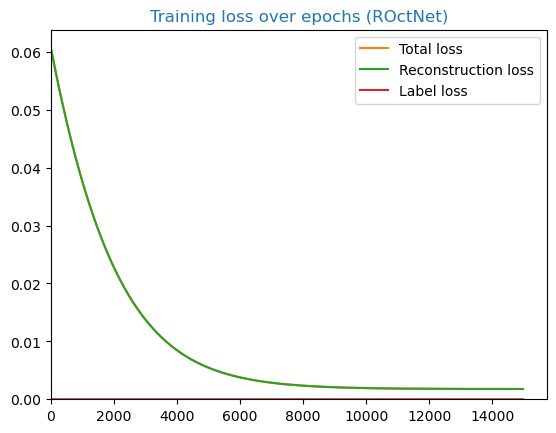

In [ ]:
print("Start training ...... ")

if config.save_log:
    fd_log = open('training_log.log', mode='a')
    fd_log.write('\n\nTraining log at '+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    fd_log.write('\n#epoch: {}'.format(config.epochs))
    fd_log.write('\nbatch_size: {}'.format(config.batch_size))
#     fd_log.write('\ncuda: {}'.format(config.cuda))
    fd_log.flush()

header = '     Time    Epoch   Chunk  Iteration    Progress(%)  ReconLoss LabelLoss TotalLoss'
log_template = ' '.join('{:>9s},{:>5.0f}/{:<5.0f},,{:>5.0f}/{:<5.0f},{:>5.0f}/{:<5.0f},{:>9.1f}%,{:>11.2f},{:>11.2f},{:>10.2f}'.split(','))

total_iter = config.epochs * math.ceil(n_samples/config.batch_size) 

if not config.no_plot:
    plot_x = [x for x in range(total_iter)]
    plot_total_loss = [None for x in range(total_iter)]
    plot_recon_loss = [None for x in range(total_iter)]
    plot_label_loss = [None for x in range(total_iter)]
    dyn_plot = DynamicPlot(title='Training loss over epochs (ROctNet)', xdata=plot_x, ydata={'Total_loss':plot_total_loss, 'Reconstruction_loss':plot_recon_loss,'Label_loss':plot_label_loss})
    iter_id = 0
    max_loss = 0
    min_loss = 0

start = time.time()

flag = True

for epoch in range(config.epochs):

    print(header)
    for base in range(1,1+n_samples,incre):
    
        if incre < n_samples or flag:
            flag = False
            #print("Loading data ...... "+str(base), end='', flush=True)
            roct_data = ROctDataset('data/forest/', base, incre)
            train_iter = torch.utils.data.DataLoader(roct_data, batch_size=config.batch_size, shuffle=True, collate_fn=my_collate)
            #valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=200, shuffle=True, collate_fn=my_collate)
            #print("DONE")

        for batch_idx, batch in enumerate(train_iter):
            # Initialize torchfold for *encoding*
            enc_fold = FoldExt(cuda=config.cuda)
            enc_fold_nodes = []     # list of fold nodes for encoding
            # Collect computation nodes recursively from encoding process
            for example in batch:
                enc_fold_nodes.append(ROctNetmodel_32.encode_structure_fold(enc_fold, example))

            # Apply the computations on the encoder model
            #set_trace()
            enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])

            # Split into a list of fold nodes per example
            enc_fold_nodes = torch.split(enc_fold_nodes[0], 1, 0)
            # Initialize torchfold for *decoding*
            dec_fold = FoldExt(cuda=config.cuda)
            # Collect computation nodes recursively from decoding process
            dec_fold_nodes = []
            for example, fnode in zip(batch, enc_fold_nodes):
                root_code = fnode
                dec_fold_nodes.append(ROctNetmodel_32.decode_structure_fold(dec_fold, root_code, example))
                #if epoch==config.epochs-1:
                    #sample_codes_all.append(root_code)
                    #print("finished!!!")

            # Apply the computations on the decoder model
            dec_fold_nodes1,dec_fold_nodes2 = map(list, zip(*dec_fold_nodes))

            recon_loss = dec_fold.apply(decoder, [dec_fold_nodes1])
            label_loss = dec_fold.apply(decoder, [dec_fold_nodes2])

            #set_trace()
                # the first dim of total_loss is for reconstruction and the second for KL divergence
            recon_loss = recon_loss[0].sum() / len(batch)               # avg. reconstruction loss per example
            label_loss = label_loss[0].sum() / len(batch)
            total_loss = recon_loss + label_loss
            #set_trace()

            if total_loss.data.cpu().numpy() < 500:
                for param_group in encoder_opt.param_groups:
                    param_group['lr'] = 1e-4
                for param_group in decoder_opt.param_groups:
                    param_group['lr'] = 1e-4


            # Do parameter optimization
            encoder_opt.zero_grad()
            decoder_opt.zero_grad()
            total_loss.backward()
            encoder_opt.step()
            decoder_opt.step()

            # Report statistics
            if batch_idx % config.show_log_every == 0:
                print(log_template.format(strftime("%H:%M:%S",time.gmtime(time.time()-start)),
                    epoch, config.epochs, math.ceil(base/incre) , math.ceil(n_samples/incre) ,1+batch_idx, len(train_iter),
                    100. * (1+batch_idx+len(train_iter)*epoch) / (len(train_iter)*config.epochs),
                    recon_loss.item(), label_loss.item(), total_loss.item()))
            # Plot losses
            if not config.no_plot and epoch>=0:
                plot_total_loss[iter_id] = total_loss.item()
                plot_recon_loss[iter_id] = recon_loss.item()
                plot_label_loss[iter_id] = label_loss.item()
                max_loss = max(max_loss, total_loss.item(), recon_loss.item(), label_loss.item())
                min_loss = min(min_loss, total_loss.item(), recon_loss.item(), label_loss.item())
                dyn_plot.setxlim(0., (iter_id+1)*1.05)
                dyn_plot.setylim(min_loss*1.05, max_loss*1.05)
                dyn_plot.update_plots(ydata={'Total_loss':plot_total_loss, 'Reconstruction_loss':plot_recon_loss,  'Label_loss':plot_label_loss})
                iter_id += 1
            
                # August 2023    
            if config.save_snapshot and (epoch+1) % config.save_snapshot_every == 0 :
                torch.save(encoder, "models/encoder_enitre_model")
                torch.save(decoder, "models/decoder_enitre_model")
                


        # Save snapshots of the models being trained
#         if config.save_snapshot and (epoch+1) % config.save_snapshot_every == 0 :
#             pass
#             print("Saving snapshots of the models ...... ", end='', flush=True)
#             torch.save(encoder, 'snapshots/vae_encoder_model_epoch_{}_loss_{:.2f}.pkl'.format(epoch+1, total_loss.item()))
#             torch.save(decoder, 'snapshots/vae_decoder_model_epoch_{}_loss_{:.2f}.pkl'.format(epoch+1, total_loss.item()))
#             print("DONE")
        # Save training log
#         if config.save_log and (epoch+1) % config.save_log_every == 0 : 
#             fd_log = open('training_log.log', mode='a')
#             fd_log.write('\nepoch:{} recon_loss:{:.2f} kld_loss:{:.2f} total_loss:{:.2f}'.format(epoch+1, recon_loss.item(), kldiv_loss.item(), total_loss.item()))
#             fd_log.close()

In [ ]:
# Save the final models
# print("Saving final models ...... ", end='', flush=True)
# torch.save(encoder, 'models/ae_encoder_plane_128_32.pkl')
# torch.save(decoder, 'models/ae_decoder_plane_128_32.pkl')
# print("DONE")

In [ ]:
# August 2023 ---> uncomment
# encoder = torch.load("models/encoder_enitre_model")
# decoder = torch.load("models/decoder_enitre_model")

In [ ]:
from torch.autograd import Variable
def encode_structure(model, tree):
    """
    Encode a tree into a code
    """
    def encode_node(node,l):
        if node.is_leaf():
            if not node.is_empty_leaf():
                # - May 20
                # return model.LeafEncoder(Variable(node.fea.cuda()))
                # + May 20
                return model.LeafEncoder(Variable(node.fea))
            else:
                # - May 20
#                 return model.LeafEncoder2(Variable(node.fea.cuda()))
                # + May 20
                return model.LeafEncoder2(Variable(node.fea))
        elif node.is_expand():
            child = []
            for i in range(8):
                child.append(encode_node(node.child[i],l+1))
            mycode = 'model.NodeEncoder'+str(l)+'(child[0], child[1],child[2],child[3],child[4],child[5],child[6],child[7])'
            return eval(mycode)

    encoding = encode_node(tree.root,1)
    root_code = model.sampleEncoder(encoding)

    return root_code

In [ ]:
from torch.autograd import Variable
def decode_structure(model, root_code):
    """
    Decode a root code into boxes
    """
    decode = model.sampleDecoder(root_code)
    stack = [decode]
    boxes = []
    ops = []
    depth = [1]

    while len(stack) > 0:
        f = stack.pop()
        d = depth.pop()
        label_prob = model.nodeClassifier(f)
        _, label = torch.max(label_prob,1)
        label = label.data.cpu().numpy()
#         print(label)
#         print(label_prob)
        ops.append(label)
        
        if label == 3: # NON-LEAF
            mycode = 'model.NodeDecoder'+str(d)+'(f)'
            child_feature1,child_feature2,child_feature3,child_feature4,child_feature5,child_feature6,child_feature7,child_feature8 = eval(mycode) 
            #print('non-leaf')               
            
            stack.append(child_feature8)
            stack.append(child_feature7)
            stack.append(child_feature6)
            stack.append(child_feature5)
            stack.append(child_feature4)
            stack.append(child_feature3)
            stack.append(child_feature2)
            stack.append(child_feature1)
            
            for i in range(8):
                depth.append(d+1)

                
        else:  # LEAF
            #print('leaf')
            reBox = model.leafDecoder(f)
            reBoxes = [reBox]
            boxes.extend(reBox)

    return boxes, ops

In [ ]:
# decoder.sampleDecoder(code).shape

In [ ]:
# decoder.nodeClassifier(decoder.sampleDecoder(code))

In [ ]:
def decode_structure2(model, root_code, tree):
    """
    Decode a root code into boxes
    """
    decode = model.sampleDecoder(root_code)
    stack = [decode]
    boxes = []
    ops = []
    depth = [tree.root]
    depth2 = [1]
    
    while len(stack) > 0:
        f = stack.pop()
        d = depth.pop()
        d2 = depth2.pop()
  
        ops.append(d.label.cpu().numpy())
    
        if d.is_expand():  # NON-LEAF
            mycode = 'model.NodeDecoder'+str(d2)+'(f)'
            child_feature1,child_feature2,child_feature3,child_feature4,child_feature5,child_feature6,child_feature7,child_feature8 = eval(mycode) 
            #print('non-leaf')          
            #print('non-leaf')
            stack.append(child_feature8)
            stack.append(child_feature7)
            stack.append(child_feature6)
            stack.append(child_feature5)
            stack.append(child_feature4)
            stack.append(child_feature3)
            stack.append(child_feature2)
            stack.append(child_feature1)

            for i in range(7,-1,-1):
                depth.append(d.child[i])
            
            for i in range(8):
                depth2.append(d2+1)

                
        else:  # LEAF
            #print('leaf')
            reBox = model.leafDecoder(f)
            # -June 10, not needed
            # reBoxes = [reBox]
            boxes.extend(reBox)

    return boxes, ops

# reconst

In [ ]:
# August 2023 ---> from 'train_1' folder to 'forest' folder
roct_data = ROctDataset('./data/forest/',1 , 2)#---> 1 in file name of fea_data1.mat, label_data1.mat, op_data1.mat
# roct_data.trees = roct_data.trees[0::]

In [ ]:
roct_data.trees[0:]

In [ ]:
#train samples reconstruction with GT octree structure
encoder = encoder.eval()
decoder = decoder.eval()
import scipy.io as sio
recons_all = []
ops_all = []
for i in range(0,1):
    code = encode_structure(encoder, roct_data.trees[i])
    recons,ops = decode_structure2(decoder, code, roct_data.trees[i])
    recons_all.append(torch.cat(recons,0).data.cpu().numpy())
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all})

In [ ]:
#  go and upload data/reconstrcted.mat on matlab. and run (in matlab) the followings:
# >> recons_all = squeeze(recons_all);
# >> [vox,label,feas_all] = get_tree_vox(permute(recons_all,[2 3 4 1]),flip(ops_all),256);
# >> save('myvoxel.mat', 'vox')

# bring myvoxel.mat in data/myvoxel.mat
# continue...

In [ ]:
# June 2023
# reading .mat file
import scipy.io
mat = scipy.io.loadmat('data/myvoxel.mat')

In [ ]:
mat['vox'].shape

In [ ]:
#  + June 2023
counter = 0
with open('./data/reconstructed.xyz', 'w') as f:
    for i in range(mat['vox'].shape[0]):
        for j in range(mat['vox'].shape[1]):
            for k in range(mat['vox'].shape[2]):
#                 print(mat['vox'][i][j][k])
                if (mat['vox'][i][j][k]>=0.5):
                    counter+=1
                    
                    f.write(f'{i} {j} {k}\n')
print(counter)

In [ ]:
256*256*256

In [ ]:
# now see './data/reconstructed.xyz' in meshlab software.

In [ ]:
#================================

In [ ]:
#train samples reconstruction
encoder = encoder.eval()
decoder = decoder.eval()



import scipy.io as sio
recons_all = []
ops_all = []
for i in range(0,1):
    code = encode_structure(encoder, roct_data.trees[i])
    # + recons are boxes
    recons,ops = decode_structure(decoder, code)
    recons_all.append(torch.cat(recons,0).data.cpu().numpy()>0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all},do_compression=True)

In [ ]:
#  go and upload data/reconstrcted.mat on matlab. and run (in matlab) the followings:
# >> recons_all = squeeze(recons_all);
# >> [vox,label,feas_all] = get_tree_vox(permute(recons_all,[2 3 4 1]),flip(ops_all),256);
# >> save('myvoxel.mat', 'vox')

# bring myvoxel.mat in data/myvoxel.mat
# continue...

In [ ]:
# June 2023
# readin .mat file
import scipy.io
mat = scipy.io.loadmat('data/myvoxel.mat')

In [ ]:
mat.keys()

In [ ]:
mat['vox'].shape

In [ ]:
mat['vox'][10][10][10]

In [ ]:
#  + June 2023
counter = 0
with open('./data/reconstructed.xyz', 'w') as f:
    for i in range(mat['vox'].shape[0]):
        for j in range(mat['vox'].shape[1]):
            for k in range(mat['vox'].shape[2]):
                if (mat['vox'][i][j][k]>=0.5):
                    counter+=1
                    f.write(f'{i} {j} {k}\n')
counter                    

In [ ]:
counter

In [ ]:
256*256*256

In [ ]:
print(recons_all[0].shape)

In [ ]:
len(ops_all), len(ops_all[0])

In [ ]:
code.shape, len(recons)

In [ ]:
code

In [ ]:
ops_all

In [ ]:
recons_all[0][0][10][10][10]

In [ ]:
print(len(ops_all[0]))

In [ ]:
print(recons_all[0].max())

In [ ]:
#morphing
encoder = encoder.eval()
decoder = decoder.eval()

import scipy.io as sio
import numpy
recons_all = []
ops_all = []
for i in numpy.arange(0,1,0.1):
    code1 = encode_structure(encoder, roct_data.trees[0*5])
    code2 = encode_structure(encoder, roct_data.trees[1*5])
    code = code1.mul(i) + code2.mul(1-i)
    recons,ops = decode_structure(decoder, code)
    recons_all.append(torch.cat(recons,0).data.cpu().numpy()>0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/morphing.mat', {'morphing_all':recons_all, 'morphing_ops_all':ops_all},do_compression=True)

In [ ]:
#read test samples
test_data = ROctDataset('/data/juncheng/shapenetcorev2/airplane/128_32_vox/shuffled_test_1',1 , 809)
#roct_data.trees = roct_data.trees[0:-1:12]
print("DONE")

len(test_data.trees)

In [ ]:
#test samples reconstruction
encoder = encoder.eval()
decoder = decoder.eval()

import scipy.io as sio
recons_all = []
ops_all = []
for i in range(len(test_data.trees)): #len(test_data.trees)
    code = encode_structure(encoder, test_data.trees[i])
    recons,ops = decode_structure(decoder, code)
      recons_all.append(torch.cat(recons,0).data.cpu().numpy()>=0.5)
    ops_all.append(ops)
    print(i)
#     print(recons)
    
sio.savemat('data/test_reconstructed.mat', {'recons_all':recons_all, 'ops_all':ops_all},do_compression=True)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(str(count_parameters(encoder)/1024/1024)+'M')
print(str(count_parameters(decoder)/1024/1024)+'M')